In [101]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import warnings
import re

# Ignore all warnings
warnings.filterwarnings('ignore')

# Arizona 2022 General Election PBER

### Load the data

Data from openelections, can be downloaded from Github at https://github.com/openelections/openelections-data-az/tree/master/2022

In [102]:
csv_path = './20221108__az__general__precinct.csv'
df = pd.read_csv(csv_path)
df.tail(5)

,county,precinct,office,district,candidate,party,votes,early_voting,election_day,provisional,late_votes
80022,Yavapai,BISON (244.00),Attorney General,NaN,Under Votes,NaN,242,219.0,23.0,0.0,NaN
80023,Yavapai,BIGHORN (245.00),Attorney General,NaN,Under Votes,NaN,114,103.0,11.0,0.0,NaN
80024,Yavapai,LASSO (246.00),Attorney General,NaN,Under Votes,NaN,7,6.0,1.0,0.0,NaN
80025,Yavapai,CHAPS (247.00),Attorney General,NaN,Under Votes,NaN,0,0.0,0.0,0.0,NaN
80026,Yavapai,SPURS (248.00),Attorney General,NaN,Under Votes,NaN,0,0.0,0.0,0.0,NaN


Another dataset from MEDSL, just for double check, in cases where openelection data does not seem correct

In [103]:
csv_path_az = '../AZ-cleaned.csv'
df_az = pd.read_csv(csv_path_az)
df_az_yuma = df_az[df_az['county_name'] == 'YUMA']
print(df_az_yuma['precinct'].unique())
df_az_yuma

['1.01' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0' '8.01' '9.0' '10.0' '11.0'
 '12.0' '13.0' '14.01' '15.01' '16.0' '17.0' '18.0' '19.0' '20.0' '22.0'
 '23.01' '24.01' '25.01' '26.0' '27.0' '28.0' '29.0' '30.01' '31.0' '32.0'
 '33.0' '34.01' '35.0' '36.0' '37.0' '38.0' '39.0' '40.0' '41.01' '42.0'
 '43.0' '45.01' '46.0']


,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_cen,state_ic,date,jurisdiction_name,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
196160,1.01,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,MARK KELLY,SENATE,EARLY VOTING,208,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
196161,2.0,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,MARK KELLY,SENATE,EARLY VOTING,255,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
196162,3.0,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,MARK KELLY,SENATE,EARLY VOTING,220,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
196163,4.0,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,MARK KELLY,SENATE,EARLY VOTING,821,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
196164,5.0,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,MARK KELLY,SENATE,EARLY VOTING,477,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466437,22.0,25.0,STATE HOUSE,True,NaN,NaN,WRITE-IN,STATE,LATE VOTES,2,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
466438,23.01,25.0,STATE HOUSE,True,NaN,NaN,WRITE-IN,STATE,LATE VOTES,1,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
466439,24.01,25.0,STATE HOUSE,True,NaN,NaN,WRITE-IN,STATE,LATE VOTES,2,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False
466440,25.01,25.0,STATE HOUSE,True,NaN,NaN,WRITE-IN,STATE,LATE VOTES,2,...,86,61,2022-11-08,YUMA,4027,YUMA,4027,True,1,False


In [104]:
non_empty_rows_district = df['district'].dropna().shape[0]

print(f"The number of non-empty rows for the column 'district' is: {non_empty_rows_district}")

The number of non-empty rows for the column 'district' is: 21079


### Clean data

In [105]:
rows_before = df.shape[0]

# Formate votes to numbers
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

# Remove rows without a candidate or without a party. Votes without a candidate are obviously not useful and votes without a party are those associated with write-in candidates
# df_cleaned = df.dropna(subset=['candidate', 'party'])
df_cleaned = df.dropna(subset=['candidate'])

rows_after = df_cleaned.shape[0]

# Remove rows without a valid vote
df_cleaned = df_cleaned[df_cleaned['votes'] > 0]

print(f"Number of rows before cleaning: {rows_before}")
print(f"Number of rows after cleaning: {rows_after}")

# Convert data types 
df_cleaned['votes'] = df_cleaned['votes'].astype(int)

# Display the cleaned data
df_cleaned.tail(5)

Number of rows before cleaning: 80027
Number of rows after cleaning: 75497


,county,precinct,office,district,candidate,party,votes,early_voting,election_day,provisional,late_votes
80020,Yavapai,WATER (242.00),Attorney General,NaN,Under Votes,NaN,179,166.0,12.0,1.0,NaN
80021,Yavapai,BURRO (243.00),Attorney General,NaN,Under Votes,NaN,173,157.0,16.0,0.0,NaN
80022,Yavapai,BISON (244.00),Attorney General,NaN,Under Votes,NaN,242,219.0,23.0,0.0,NaN
80023,Yavapai,BIGHORN (245.00),Attorney General,NaN,Under Votes,NaN,114,103.0,11.0,0.0,NaN
80024,Yavapai,LASSO (246.00),Attorney General,NaN,Under Votes,NaN,7,6.0,1.0,0.0,NaN


In [106]:
# Clean and standardize the 'party' column
df_cleaned['party'] = df_cleaned['party'].str.strip().str.upper()

unique_parties = df_cleaned['party'].unique()
df_cleaned['office'] = df_cleaned['office'].str.strip().str.upper()
df_cleaned['candidate'] = df_cleaned['candidate'].str.strip().str.upper()

# Display the unique values for 'office', 'candidate', and 'party'
unique_offices = df_cleaned['office'].unique()
unique_candidates = df_cleaned['candidate'].unique()
unique_parties = df_cleaned['party'].unique()

print(f"Unique values in 'office':\n{unique_offices}")
print(f"\nUnique values in 'candidate':\n{unique_candidates}")
print(f"\nUnique values in 'party':\n{unique_parties}")

# Count the number of unique candidates for each office
unique_candidates_per_office = df_cleaned.groupby('office')['candidate'].nunique()

print("Number of unique candidates for each office:")
print(unique_candidates_per_office)

# Clean and standardize the 'office', 'candidate', and 'party' columns
df_cleaned['office'] = df_cleaned['office'].str.strip().str.upper()
df_cleaned['candidate'] = df_cleaned['candidate'].str.strip().str.upper()
df_cleaned['party'] = df_cleaned['party'].str.strip().str.upper()

# Categorize duplicated parties
df_cleaned['party'] = df_cleaned['party'].replace({
    'WRITE IN DEM': 'DEM',
    'LBT': 'LIB',
})

df_cleaned['party'] = df_cleaned['party'].fillna('N')

Unique values in 'office':
['U.S. SENATE' 'U.S. HOUSE' 'GOVERNOR' 'SECRETARY OF STATE'
 'ATTORNEY GENERAL' 'STATE TREASURER' 'STATE MINE INSPECTOR'
 'CORPORATION COMMISSIONER' 'STATE SENATE' 'STATE HOUSE']

Unique values in 'candidate':
['MARK KELLY' 'BLAKE MASTERS' 'MARC J. VICTOR' 'WRITE-INS'
 "TOM O'HALLERAN" 'ELI CRANE' 'JAVIER GARCIA RAMOS' 'ANDY BIGGS'
 'CLINT WILLIAM SMITH' 'KIRSTEN ENGEL' 'JUAN CISCOMANI' 'RAUL GRIJALVA'
 'LUIS POZZOLO' 'KATIE HOBBS' 'KARI LAKE' 'ADRIAN FONTES' 'MARK FINCHEM'
 'KRIS MAYES' 'ABRAHAM "ABE" HAMADEH' 'MARTIN QUEZADA' 'KIMBERLY YEE'
 'PAUL MARSH' 'SANDRA KENNEDY' 'LAUREN KUBY' 'NICHOLAS "NICK" MYERS'
 'KEVIN THOMPSON' 'KYLE NITSCHKE' 'WENDY ROGERS'
 'DAVID CHRISTIAN FARNSWORTH' 'NICK FIERRO' 'ALAN SMITH' 'JAKE HOFFMAN'
 'TAYLOR KERBY' 'THOMAS "T.J." SHOPE' 'MIKE NICKERSON' 'JUSTINE WADSACK'
 'BRIAN FERNANDEZ' 'GARY GARCIA SNYDER' 'DAVID COOK' 'DAVID MARSHALL SR.'
 'HELEN HUNTER' 'JUSTIN HEAP' 'BARBARA ROWLEY PARKER' 'NEAL CARTER'
 'JACUELINE PARKER'

## Process Election Data

In [107]:
# Create a mapping for 'office'
office_mapping = {
    'ATTORNEY GENERAL': 'ATT',
    'CORPORATION COMMISSIONER': 'COR',
    'GOVERNOR': 'GOV',
    'SECRETARY OF STATE': 'SOS',
    'STATE HOUSE': 'STH',
    'STATE MINE INSPECTOR': 'STM',
    'STATE SENATE': 'STS',
    'STATE TREASURER': 'STT',
    'U.S. HOUSE': 'USH',
    'U.S. SENATE': 'USS'
}

# Function to create a unique column name
def create_column_name(row, existing_names):
    office_abbr = office_mapping.get(row['office'], '')
    party_initial = row['party'][0]
    last_name = row['candidate'].split()[-1][:3].upper()
    
    if pd.notna(row['district']):
        district = str(int(row['district']))  # Ensure district is not a float
        base_name = f"G{office_abbr}{district}{party_initial}{last_name}"
    else:
        base_name = f"G22{office_abbr}{party_initial}{last_name}"
    
    # Ensure the column name is unique(make sure no candidates with similar or same last name running for the same position will be counted as one)
    if base_name not in existing_names:
        return base_name
    else:
        suffix = 1
        new_name = f"{base_name}_{suffix}"
        while new_name in existing_names:
            suffix += 1
            new_name = f"{base_name}_{suffix}"
        return new_name

# Get unique combinations of counties and precincts
unique_combinations = df_cleaned[['county', 'precinct']].drop_duplicates()

# Initialize an empty list to store the results
results = []

# Iterate each row and group together rows with the same county and precinct
for _, row in unique_combinations.iterrows():
    county = row['county']
    precinct = row['precinct']
    
    # Filter for the specific county and precinct
    filtered_df = df_cleaned[(df_cleaned['county'] == county) & (df_cleaned['precinct'] == precinct)]
    
    # Track existing column names to ensure uniqueness
    existing_names = set()
    
    # Apply the function to create new column names
    filtered_df['ColumnName'] = filtered_df.apply(lambda row: create_column_name(row, existing_names), axis=1)
    
    # Update the set of existing names
    existing_names.update(filtered_df['ColumnName'].tolist())
    
    # Pivot dataset so that each row represents a precinct and each column represents a candidate
    pivoted_df = filtered_df.pivot_table(
        index=['county', 'precinct'],
        columns='ColumnName',
        values='votes',
        aggfunc='first'
    )
    
    # Flatten the columns
    pivoted_df.columns = [col for col in pivoted_df.columns]
    
    # Reset index
    pivoted_df.reset_index(inplace=True)
    
    # Append results
    results.append(pivoted_df)

# Concatenate all results
final_df = pd.concat(results, ignore_index=True)

# Display the final DataFrame
print(final_df)

       county          precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
0       Pinal         01 Kearny       374.0       402.0       347.0   
1       Pinal    04 Dudleyville       208.0       146.0       205.0   
2       Pinal     05 San Manuel       525.0       608.0       479.0   
3       Pinal        06 Mammoth       303.0       134.0       291.0   
4       Pinal         07 Oracle        26.0        72.0        26.0   
...       ...               ...         ...         ...         ...   
1689  Yavapai    BURRO (243.00)      1968.0      4162.0         NaN   
1690  Yavapai    BISON (244.00)      2622.0      5198.0         NaN   
1691  Yavapai  BIGHORN (245.00)      1219.0      2245.0         NaN   
1692  Yavapai    LASSO (246.00)        42.0       144.0         NaN   
1693  Yavapai    CHAPS (247.00)         NaN         2.0         NaN   

      G22CORDKUB  G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  \
0          307.0       389.0       387.0       353.0         5.0  ...   
1

### Count # of precincts for each county

In [108]:
count_unique_df1 = final_df.groupby('county')['precinct'].nunique()
for county, count in count_unique_df1.items():
    print(f"{county}: {count}")

Apache: 44
Cochise: 54
Coconino: 75
Gila: 39
Graham: 22
Greenlee: 8
La Paz: 11
Maricopa: 904
Mohave: 24
Navajo: 14
Pima: 266
Pinal: 108
Santa Cruz: 35
Yavapai: 46
Yuma: 44


### Read AZ 2020 shapefile for potential re-use, in case where 2022 data is not available

                                               geometry        PRECINCTNA  \
0     POLYGON ((-109.49567 33.65280, -109.49576 33.6...            ALPINE   
1     POLYGON ((-109.71666 36.26151, -109.71658 36.2...  CANYON DE CHELLY   
2     POLYGON ((-109.81183 36.27512, -109.80810 36.2...            CHINLE   
3     POLYGON ((-109.53982 34.44871, -109.53928 34.4...            CONCHO   
4     POLYGON ((-109.81768 36.14760, -109.81822 36.1...        COTTONWOOD   
...                                                 ...               ...   
1484  POLYGON ((-109.27632 33.13312, -109.27637 33.1...         CLIFTON 1   
1485  POLYGON ((-109.31894 33.05199, -109.31855 33.0...    EAST PLANTSITE   
1486  POLYGON ((-112.04047 34.80011, -112.04045 34.8...             GHOST   
1487  POLYGON ((-111.49511 33.99991, -111.49533 33.9...               BUG   
1488  POLYGON ((-112.36189 34.53000, -112.36191 34.5...              IRON   

     COUNTY_NAM            UNIQUE_ID  
0        Apache            02 ALPINE

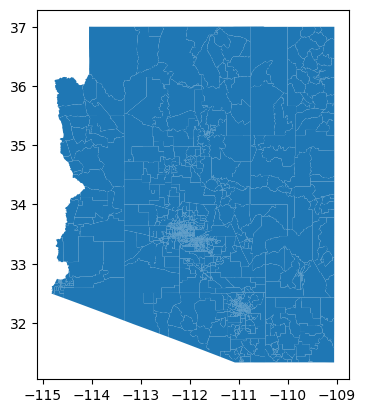

In [109]:

# Read the shapefile
shapefile_path = '../az_gen_20_prec/az_gen_20_prec.shp'
gdf = gpd.read_file(shapefile_path)

# Select only the desired columns
selected_columns = ['geometry', 'PRECINCTNA', 'COUNTY_NAM', 'UNIQUE_ID']
gdf_2020 = gdf[selected_columns]

# Define this remove special character function for future use
def remove_special_characters(column):
    return column.str.replace(r'[^\w\s]', '', regex=True)

# Apply the function to the selected columns
gdf_2020['PRECINCTNA'] = remove_special_characters(gdf_2020['PRECINCTNA'])
gdf_2020['COUNTY_NAM'] = remove_special_characters(gdf_2020['COUNTY_NAM'])
gdf_2020['UNIQUE_ID'] = remove_special_characters(gdf_2020['UNIQUE_ID'])

# Display the first few rows of the filtered GeoDataFrame
print(gdf_2020)

# Plot the shapefile with the filtered data
gdf_2020.plot()
plt.show()



## Process precinct boundaries by county

### Coconino County

In [110]:
# Filter rows 
coconino_rows = final_df[final_df['county'].str.lower() == 'coconino']

# Display the filtered rows
print(coconino_rows.head(5))

       county          precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
299  Coconino  01 - FLAGSTAFF 1      1000.0       264.0       919.0   
300  Coconino  02 - FLAGSTAFF 2       800.0       127.0       756.0   
301  Coconino  03 - FLAGSTAFF 3       618.0       110.0       594.0   
302  Coconino  04 - FLAGSTAFF 4      1032.0       312.0       951.0   
303  Coconino  05 - FLAGSTAFF 5      1174.0       471.0      1112.0   

     G22CORDKUB  G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  \
299       915.0       262.0       233.0      1011.0         1.0  ...   
300       742.0       135.0       132.0       814.0         2.0  ...   
301       584.0        98.0       106.0       627.0         6.0  ...   
302       942.0       322.0       301.0      1066.0         2.0  ...   
303      1073.0       453.0       416.0      1193.0         6.0  ...   

     G22GOVWNOV  GSTH30NVOT  GSTH30RBIS  GSTS30NVOT  G22USSWBUL  G22GOVWDEN  \
299         NaN         NaN         NaN         NaN         N

75


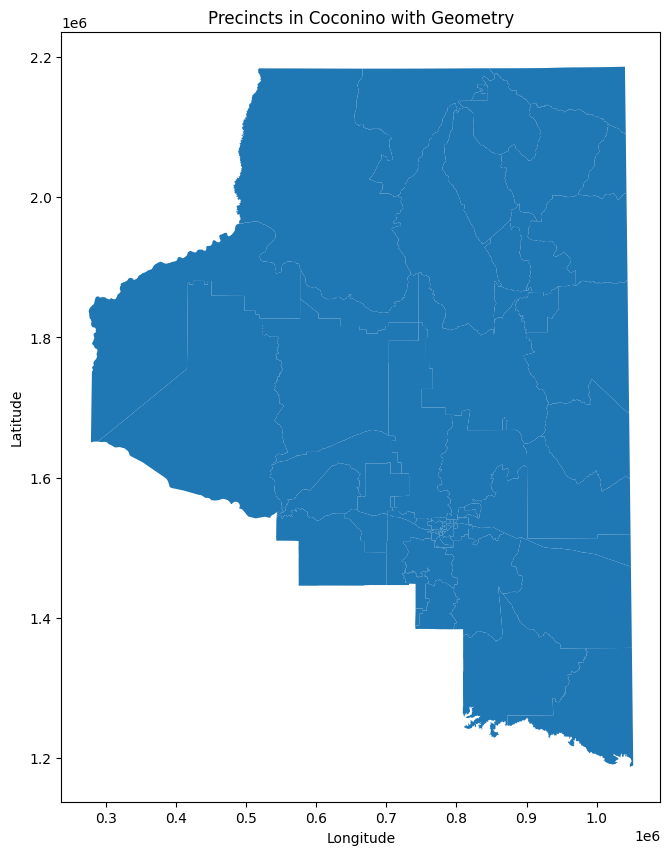

In [111]:
# Read in the GeoJSON file
geojson_file_Cococino = './precinct_boundaries/Cococino.geojson'
gdf_Cococino = gpd.read_file(geojson_file_Cococino)

print(len(gdf_Cococino))

final_df_Coconino = coconino_rows

# Extract the numerical part from the precinct values
final_df_Coconino['precinct'] = final_df_Coconino['precinct'].str.extract('(\d+)')[0].astype(int)

gdf_Cococino['VOTENUM'] = gdf_Cococino['VOTENUM'].astype(int)


# Merge the DataFrames on precinct_num and VOTENUM
merged_df = final_df_Coconino.merge(gdf_Cococino[['VOTENUM', 'geometry']], left_on='precinct', right_on='VOTENUM', how='left')

# Convert final_df to a GeoDataFrame
gdf_Cococino_final = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Plot the geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_Cococino_final.plot(ax=ax)
plt.title("Precincts in Coconino with Geometry")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [112]:
gdf_Cococino_final.drop(columns=['VOTENUM'], inplace=True)
gdf_Cococino_final.head(5)

,county,precinct,G22ATTDMAY,G22ATTRHAM,G22CORDKEN,G22CORDKUB,G22CORRMYE,G22CORRTHO,G22GOVDHOB,G22GOVNWRI,...,GSTH30NVOT,GSTH30RBIS,GSTS30NVOT,G22USSWBUL,G22GOVWDEN,G22GOVWMER,G22USSWBOR,G22GOVWCAM,G22USSWROX,geometry
0,Coconino,1,1000.0,264.0,919.0,915.0,262.0,233.0,1011.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((785865.395 1532109.130, 785894.714 1..."
1,Coconino,2,800.0,127.0,756.0,742.0,135.0,132.0,814.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((785237.611 1534472.194, 784828.852 1..."
2,Coconino,3,618.0,110.0,594.0,584.0,98.0,106.0,627.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((781398.115 1530200.808, 781383.637 1..."
3,Coconino,4,1032.0,312.0,951.0,942.0,322.0,301.0,1066.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((776275.689 1539747.216, 776351.992 1..."
4,Coconino,5,1174.0,471.0,1112.0,1073.0,453.0,416.0,1193.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((785145.855 1542697.010, 785351.031 1..."


### Apache County


                                               geometry        PRECINCTNA  \
0     POLYGON ((-109.49567 33.65280, -109.49576 33.6...            ALPINE   
1     POLYGON ((-109.71666 36.26151, -109.71658 36.2...  CANYON DE CHELLY   
2     POLYGON ((-109.81183 36.27512, -109.80810 36.2...            CHINLE   
3     POLYGON ((-109.53982 34.44871, -109.53928 34.4...            CONCHO   
4     POLYGON ((-109.81768 36.14760, -109.81822 36.1...        COTTONWOOD   
5     POLYGON ((-109.16169 34.44067, -109.16175 34.4...          CORONADO   
6     POLYGON ((-110.00068 36.62770, -110.00068 36.6...        DENNEHOTSO   
7     POLYGON ((-109.29166 34.11102, -109.29168 34.1...             EAGAR   
8     POLYGON ((-109.04689 34.09608, -109.04689 34.0...          FLAT TOP   
9     POLYGON ((-109.50325 35.79129, -109.50325 35.7...      GANADO NORTH   
10    POLYGON ((-109.46441 35.71808, -109.46460 35.7...      GANADO SOUTH   
11    POLYGON ((-109.45814 33.88965, -109.45891 33.8...             GREER   

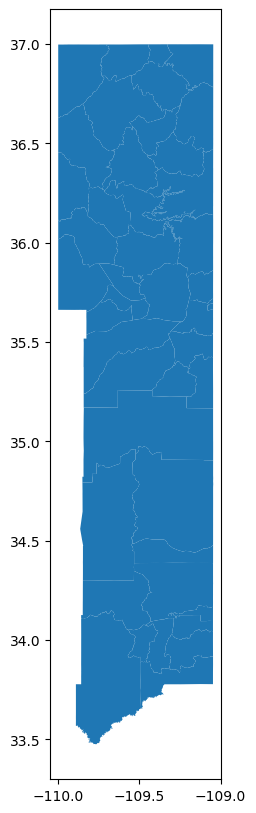

In [113]:
apache_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Apache']
print(apache_2020)
# Plot the geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
apache_2020.plot(ax=ax)
plt.show()

In [114]:
apache_rows = final_df[final_df['county'].str.lower() == 'apache']
apache_rows['precinct'] = apache_rows['precinct'].str.upper()
# Display the filtered rows
print(apache_rows)

     county             precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
374  Apache            02 ALPINE        96.0       278.0        93.0   
375  Apache  03 CANYON DE CHELLY      1412.0       168.0      1131.0   
376  Apache            05 CHINLE       729.0       103.0       631.0   
377  Apache            09 CONCHO       307.0      1251.0       273.0   
378  Apache        10 CORNFIELDS       330.0        44.0       285.0   
379  Apache        11 COTTONWOOD       565.0        62.0       425.0   
380  Apache          12 CORONADO       120.0       599.0       107.0   
381  Apache        13 DENNEHOTSO       439.0        61.0       298.0   
382  Apache             16 EAGAR       144.0       686.0       136.0   
383  Apache          17 FLAT TOP       101.0       520.0        85.0   
384  Apache       19 FT DEFIANCE      1418.0       224.0      1204.0   
385  Apache      22 GANADO NORTH       283.0        35.0       230.0   
386  Apache      23 GANADO SOUTH       527.0        65.0       4

In [115]:
# Merge the dataframes on UNIQUE_ID and precinct
gdf_Apache = apache_rows.merge(apache_2020[['UNIQUE_ID', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='UNIQUE_ID', 
                                       how='left')

# Drop the duplicate UNIQUE_ID column from the merged DataFrame
gdf_Apache_final = gdf_Apache.drop(columns=['UNIQUE_ID'])


# Display the final DataFrame
print(gdf_Apache_final.head(5))

   county             precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
0  Apache            02 ALPINE        96.0       278.0        93.0   
1  Apache  03 CANYON DE CHELLY      1412.0       168.0      1131.0   
2  Apache            05 CHINLE       729.0       103.0       631.0   
3  Apache            09 CONCHO       307.0      1251.0       273.0   
4  Apache        10 CORNFIELDS       330.0        44.0       285.0   

   G22CORDKUB  G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  \
0        86.0       252.0       260.0       106.0         2.0  ...   
1       948.0       123.0       207.0      1407.0         4.0  ...   
2       517.0        86.0       100.0       721.0         2.0  ...   
3       251.0      1106.0      1117.0       312.0        11.0  ...   
4       227.0        37.0        42.0       329.0         NaN  ...   

   GSTH30NVOT  GSTH30RBIS  GSTS30NVOT  G22USSWBUL  G22GOVWDEN  G22GOVWMER  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1   

### Cochise County

In [116]:
cochise_rows = final_df[final_df['county'].str.lower() == 'cochise']
cochise_rows['precinct'] = remove_special_characters(cochise_rows['precinct'])
cochise_rows['precinct'] = cochise_rows['precinct'].str.extract('(\d+)')[0].astype(str).str.lstrip('0').astype(int)

print(cochise_rows.head(5))

      county  precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
187  Cochise         1       358.0       702.0         NaN         NaN   
188  Cochise         2       405.0      1016.0         NaN         NaN   
189  Cochise         3       454.0       773.0         NaN         NaN   
190  Cochise         4       794.0       184.0         NaN         NaN   
191  Cochise         5       534.0       293.0         NaN         NaN   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  G22GOVWNOV  \
187         NaN         NaN       361.0         7.0  ...         NaN   
188         NaN         NaN       422.0         NaN  ...         NaN   
189         NaN         NaN       464.0        11.0  ...         NaN   
190         NaN         NaN       802.0         1.0  ...         NaN   
191         NaN         NaN       546.0         3.0  ...         NaN   

     GSTH30NVOT  GSTH30RBIS  GSTS30NVOT  G22USSWBUL  G22GOVWDEN  G22GOVWMER  \
187         NaN         NaN         NaN    

   OBJECTID                              globalid  prct_num     prct_name  \
0         1  efa5a3b7-b7d3-4555-917f-4c4742e72738         1     BE BENSON   
1         2  cb17a37a-8422-499f-a4e8-7fe0f79a7609         2      BE J-SIX   
2         3  1b83f1df-627d-48bc-bfd2-795611e6043c         3  BE SAN PEDRO   
3         4  46b31677-56c0-4edd-b0d5-676e713e7ae7         4     BI BISBEE   
4         5  eae5a681-3286-4913-acbc-fccda493d142         5   BI DON LUIS   

   bos  college  jp  lg  cd                                           geometry  
0    3        1   3  19   6  POLYGON ((-110.27949 31.97802, -110.27925 31.9...  
1    3        1   3  19   6  POLYGON ((-110.42593 32.05329, -110.42571 32.0...  
2    3        1   3  19   6  POLYGON ((-110.29743 31.96849, -110.29728 31.9...  
3    2        5   1  21   7  POLYGON ((-109.82375 31.51770, -109.82375 31.5...  
4    2        5   1  21   7  POLYGON ((-110.03750 31.37986, -110.03751 31.3...  
    OBJECTID                              globalid 

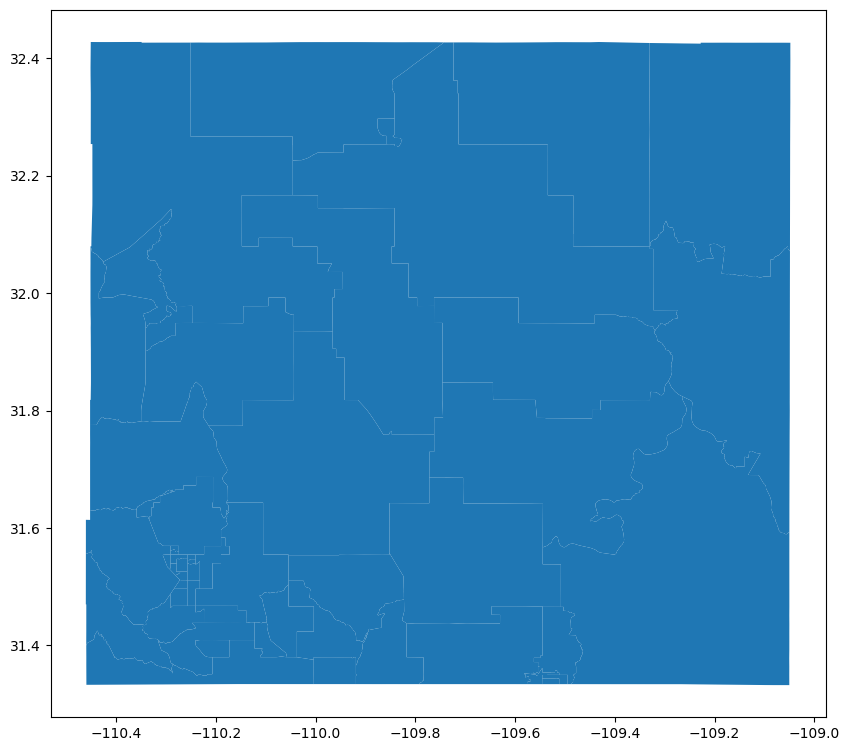

In [117]:
# Read the shapefile
shapefile_path_Cochise = './precinct_boundaries/Chochise/Election_Precinct_2022.shp'
gdf_Cochise = gpd.read_file(shapefile_path_Cochise)

print(gdf_Cochise.head(5))
# Display the final DataFrame
print(gdf_Cochise)
# Plot the geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_Cochise.plot(ax=ax)
plt.show()


In [118]:
# Merge the dataframes
gdf_Cochise_final = cochise_rows.merge(gdf_Cochise[['prct_num', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='prct_num', 
                                       how='left')

# Drop the duplicate col
gdf_Cochise_final = gdf_Cochise_final.drop(columns=['prct_num'])


### Gila County

In [119]:
gila_rows = final_df[final_df['county'].str.lower() == 'gila']
gila_rows['precinct'] = remove_special_characters(gila_rows['precinct'])
def clean_precinct(precinct):
    precinct = precinct.replace(' ', '')
    precinct = precinct[:-3]
    return precinct

gila_rows['precinct'] = gila_rows['precinct'].apply(lambda x: clean_precinct(x))

print(gila_rows)

    county            precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
241   Gila           CanyonDay       247.0        20.0       236.0   
242   Gila             Carrizo        22.0         2.0        20.0   
243   Gila      CentralHeights        97.0       133.0        91.0   
244   Gila           Claypool1       154.0       273.0       152.0   
245   Gila           Claypool2       187.0       227.0       167.0   
246   Gila           Claypool3       143.0       104.0       125.0   
247   Gila         CopperBasin       251.0       109.0       232.0   
248   Gila           EastGlobe       231.0       356.0       212.0   
249   Gila              Gisela        95.0       276.0        99.0   
250   Gila              Globe1       136.0       252.0       135.0   
251   Gila             Globe11       170.0       274.0       149.0   
252   Gila              Globe2        75.0        70.0        75.0   
253   Gila              Globe3        38.0        34.0        36.0   
254   Gila          

   COUNTYFP10              NAME20 STATEFP10 VTDI10 VTDST10 JPCourt  \
0         007            ZaneGrey        04      A      36  Payson   
1         007     WhisperingPines        04      A      35  Payson   
2         007             Payson4        04      A      29  Payson   
3         007             Payson5        04      A      33  Payson   
4         007          StarValley        04      A      34  Payson   
5         007             Payson6        04      A      30  Payson   
6         007             Payson2        04      A      27  Payson   
7         007             Payson7        04      A      31  Payson   
8         007             Payson3        04      A      28  Payson   
9         007             Payson8        04      A      32  Payson   
10        007  PineStrawberryWest        04      A      39  Payson   
11        007              Gisela        04      A      37  Payson   
12        007               Young        04      A      38  Payson   
13        007       

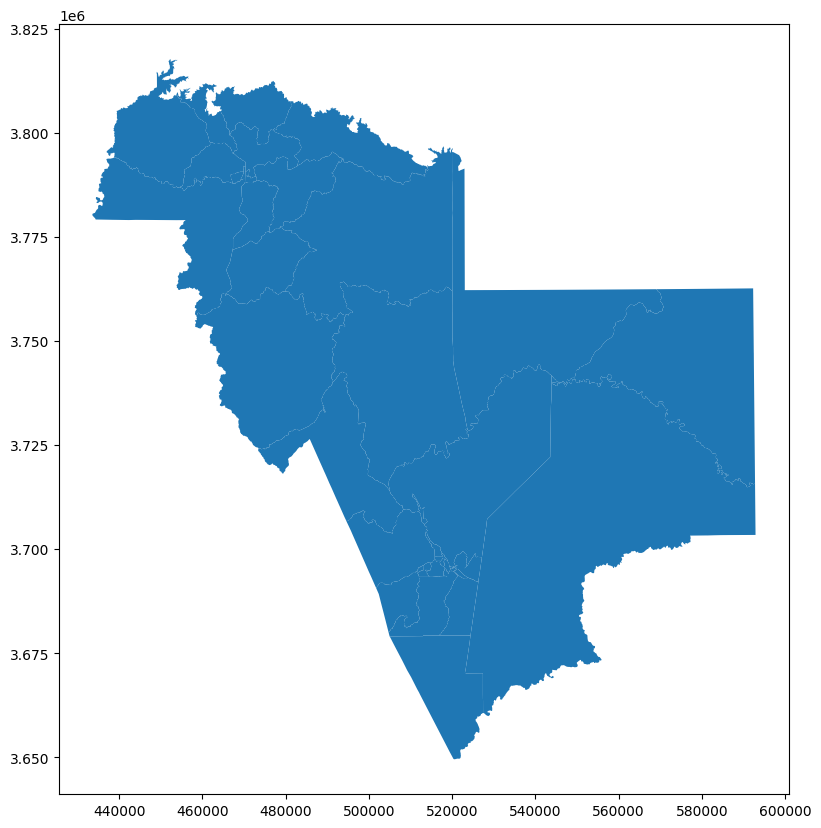

In [120]:
# Read the shapefile
shapefile_path_Gila = './precinct_boundaries/Gela/GilaPrecincts_Dec2022.shp'
gdf_Gila = gpd.read_file(shapefile_path_Gila)
gdf_Gila['NAME20'] = remove_special_characters(gdf_Gila['NAME20'])
gdf_Gila['NAME20'] = gdf_Gila['NAME20'].str.replace(' ', '')

print(gdf_Gila)
# Display the final DataFrame
# Plot the geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_Gila.plot(ax=ax)
plt.show()

In [121]:
# Merge the dataframes
gdf_Gila_final = gila_rows.merge(gdf_Gila[['NAME20', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME20', 
                                       how='right')

# Drop the duplicate col
gdf_Gila_final = gdf_Gila_final.drop(columns=['NAME20'])


# Display the final DataFrame
print(gdf_Gila_final)

   county            precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Gila            ZaneGrey       157.0       339.0       130.0       133.0   
1    Gila     WhisperingPines        50.0       140.0        45.0        37.0   
2    Gila             Payson4       265.0       559.0       264.0       225.0   
3    Gila             Payson5       364.0       951.0       320.0       286.0   
4    Gila          StarValley       474.0      1460.0       446.0       410.0   
5    Gila             Payson6       225.0       565.0       202.0       188.0   
6    Gila             Payson2       380.0      1043.0       364.0       345.0   
7    Gila             Payson7       185.0       464.0       171.0       153.0   
8    Gila             Payson3       586.0      1452.0       522.0       494.0   
9    Gila             Payson8       320.0       742.0       303.0       258.0   
10   Gila  PineStrawberryWest       452.0       980.0       418.0       370.0   
11   Gila              Gisel

## Graham County

    NAME                                           geometry
0      1  POLYGON ((-109.66258 32.42690, -109.66277 32.4...
1      2  POLYGON ((-109.59269 32.99641, -109.59255 32.9...
2      3  POLYGON ((-109.55933 33.05135, -109.55917 33.0...
3      4  POLYGON ((-109.68192 32.80205, -109.68629 32.8...
4      5  POLYGON ((-109.66423 33.01452, -109.66474 33.0...
5      6  POLYGON ((-109.76912 32.84913, -109.76895 32.8...
6      7  POLYGON ((-109.77388 32.88395, -109.77384 32.8...
7      8  POLYGON ((-110.19359 32.70299, -110.19364 32.7...
8      9  POLYGON ((-109.90973 33.16267, -109.91065 33.1...
9     10  POLYGON ((-110.05476 32.87796, -110.05476 32.8...
10    11  POLYGON ((-109.85487 32.59173, -109.85487 32.5...
11    12  POLYGON ((-109.68192 32.80205, -109.67634 32.8...
12    13  POLYGON ((-109.72197 32.82108, -109.72197 32.8...
13    14  POLYGON ((-109.49568 33.65283, -109.49552 33.6...
14    15  POLYGON ((-109.82829 32.82195, -109.82833 32.8...
15    16  POLYGON ((-109.76285 32.80761,

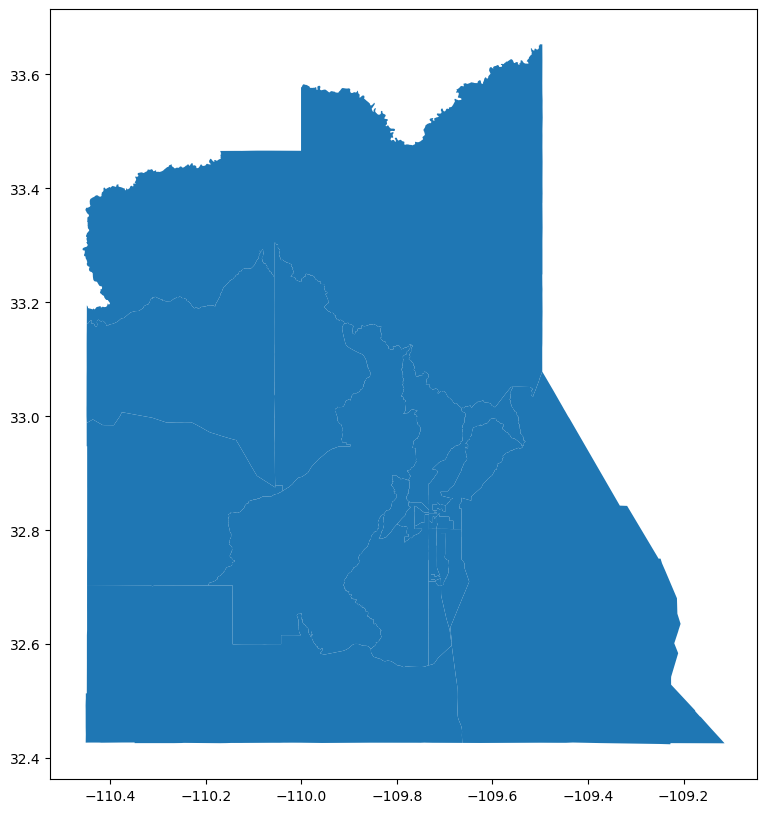

In [122]:
geojson_file_Graham = './precinct_boundaries/Graham.geojson'
gdf_Graham = gpd.read_file(geojson_file_Graham)
if len(gdf_Graham) != 22:
    raise ValueError("The GeoDataFrame must have exactly 22 rows.")

# Assign values from 1 to 22 to the 'name' column
gdf_Graham['NAME'] = range(1, 23)
print(gdf_Graham)
# Plot the geometries
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_Graham.plot(ax=ax)
plt.show()

In [123]:
graham_rows = final_df[final_df['county'].str.lower() == 'graham']
graham_rows['precinct'] = graham_rows['precinct'].str.extract('(\d+)')[0].astype(int)


print(graham_rows)

      county  precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
1612  Graham         1       196.0       388.0       188.0       154.0   
1613  Graham         2       304.0       525.0       281.0       233.0   
1614  Graham         3       125.0       284.0       121.0        89.0   
1615  Graham         4       147.0       188.0       128.0       109.0   
1616  Graham         5       252.0       576.0       224.0       182.0   
1617  Graham         6        86.0       446.0        66.0        68.0   
1618  Graham         7       269.0       812.0       231.0       198.0   
1619  Graham         8        45.0       354.0        40.0        27.0   
1620  Graham         9       275.0      1316.0       248.0       197.0   
1621  Graham        10        22.0       148.0        14.0        15.0   
1622  Graham        11       268.0        28.0       233.0       164.0   
1623  Graham        12        13.0        35.0        13.0        11.0   
1624  Graham        13        11.0    

In [124]:
# Merge the dataframes
gdf_Graham_final = graham_rows.merge(gdf_Graham[['NAME', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME', 
                                       how='left')

# Drop the duplicate col
gdf_Graham_final = gdf_Graham_final.drop(columns=['NAME'])

# Display the final DataFrame
print(gdf_Graham_final)

    county  precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0   Graham         1       196.0       388.0       188.0       154.0   
1   Graham         2       304.0       525.0       281.0       233.0   
2   Graham         3       125.0       284.0       121.0        89.0   
3   Graham         4       147.0       188.0       128.0       109.0   
4   Graham         5       252.0       576.0       224.0       182.0   
5   Graham         6        86.0       446.0        66.0        68.0   
6   Graham         7       269.0       812.0       231.0       198.0   
7   Graham         8        45.0       354.0        40.0        27.0   
8   Graham         9       275.0      1316.0       248.0       197.0   
9   Graham        10        22.0       148.0        14.0        15.0   
10  Graham        11       268.0        28.0       233.0       164.0   
11  Graham        12        13.0        35.0        13.0        11.0   
12  Graham        13        11.0       112.0        11.0        

## Greenlee County
Using 2020 boundaries(2022 boundaries provided are school districts not precinct)

In [125]:
greenlee_rows = final_df[final_df['county'].str.lower() == 'greenlee']
greenlee_rows['precinct'] = greenlee_rows['precinct'].str[4:].str.upper()
greenlee_rows['precinct'] = remove_special_characters(greenlee_rows['precinct'])

print(greenlee_rows)

       county        precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
280  Greenlee            BLUE         4.0        28.0         4.0         3.0   
281  Greenlee       CLIFTON 1       240.0       212.0       238.0       200.0   
282  Greenlee       CLIFTON 2       190.0       146.0       175.0       155.0   
283  Greenlee         MORENCI       181.0       290.0       172.0       137.0   
284  Greenlee  EAST PLANTSITE        36.0        73.0        32.0        23.0   
285  Greenlee     YORKSHELDON       150.0       301.0       138.0       108.0   
286  Greenlee          DUNCAN       136.0       397.0       126.0       115.0   
287  Greenlee           EAGLE         1.0        15.0         1.0         1.0   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  G22GOVWNOV  \
280        28.0        27.0         4.0         NaN  ...         NaN   
281       195.0       197.0       235.0         NaN  ...         NaN   
282       144.0       141.0       188.0         NaN  .

In [126]:
greenlee_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Greenlee']
print(greenlee_2020)

                                               geometry      PRECINCTNA  \
1478  POLYGON ((-109.19025 33.20995, -109.18937 33.2...       CLIFTON 2   
1479  POLYGON ((-109.22429 32.70130, -109.22429 32.7...          DUNCAN   
1480  POLYGON ((-109.23301 32.71849, -109.23936 32.7...     YORKSHELDON   
1481  POLYGON ((-109.41245 32.97681, -109.42544 32.9...         MORENCI   
1482  POLYGON ((-109.49558 33.58165, -109.49560 33.5...           EAGLE   
1483  POLYGON ((-109.04751 33.10739, -109.04755 33.1...            BLUE   
1484  POLYGON ((-109.27632 33.13312, -109.27637 33.1...       CLIFTON 1   
1485  POLYGON ((-109.31894 33.05199, -109.31855 33.0...  EAST PLANTSITE   

     COUNTY_NAM           UNIQUE_ID  
1478   Greenlee       004 CLIFTON 2  
1479   Greenlee          008 DUNCAN  
1480   Greenlee     007 YORKSHELDON  
1481   Greenlee         005 MORENCI  
1482   Greenlee           001 EAGLE  
1483   Greenlee            002 BLUE  
1484   Greenlee       003 CLIFTON 1  
1485   Greenlee  006

In [127]:
# Merge the dataframes
gdf_Greenlee_final = greenlee_rows.merge(greenlee_2020[['PRECINCTNA', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='PRECINCTNA', 
                                       how='left')

# Drop the duplicate col
gdf_Greenlee_final = gdf_Greenlee_final.drop(columns=['PRECINCTNA'])

# Display the final DataFrame
print(gdf_Greenlee_final)

     county        precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0  Greenlee            BLUE         4.0        28.0         4.0         3.0   
1  Greenlee       CLIFTON 1       240.0       212.0       238.0       200.0   
2  Greenlee       CLIFTON 2       190.0       146.0       175.0       155.0   
3  Greenlee         MORENCI       181.0       290.0       172.0       137.0   
4  Greenlee  EAST PLANTSITE        36.0        73.0        32.0        23.0   
5  Greenlee     YORKSHELDON       150.0       301.0       138.0       108.0   
6  Greenlee          DUNCAN       136.0       397.0       126.0       115.0   
7  Greenlee           EAGLE         1.0        15.0         1.0         1.0   

   G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  GSTH30NVOT  \
0        28.0        27.0         4.0         NaN  ...         NaN   
1       195.0       197.0       235.0         NaN  ...         NaN   
2       144.0       141.0       188.0         NaN  ...         NaN   
3       

### La Paz County
Using 2020 boundaries

In [128]:
la_paz_rows = final_df[final_df['county'].str.lower() == 'la paz']
la_paz_rows['precinct'] = la_paz_rows['precinct'].str.upper()

print(la_paz_rows)

     county              precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
288  La Paz            051 PARKER       596.0       676.0       533.0   
289  La Paz            052 POSTON       113.0        57.0       105.0   
290  La Paz           054 UPRIVER       245.0       879.0       216.0   
291  La Paz             055 BOUSE        74.0       284.0        70.0   
292  La Paz            056 WENDEN        29.0        68.0        28.0   
293  La Paz            057 SALOME       159.0       512.0       130.0   
294  La Paz    058 QUARTZSITE TWO       211.0       578.0       187.0   
295  La Paz            059 CIBOLA        17.0        57.0         8.0   
296  La Paz         060 EHRENBERG        38.0       180.0        34.0   
297  La Paz         062 VICKSBURG        54.0       167.0        46.0   
298  La Paz  064 QUARTZSITE THREE       112.0       317.0        98.0   

     G22CORDKUB  G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  \
288       443.0       622.0       601.0       592.0

In [129]:
la_paz_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'La Paz']
print(la_paz_2020)

                                               geometry    PRECINCTNA  \
98    POLYGON ((-114.34848 33.78091, -114.34849 33.7...        POSTON   
99    POLYGON ((-113.84995 34.24601, -113.84995 34.2...       UPRIVER   
100   POLYGON ((-113.42871 33.37691, -113.42871 33.3...        SALOME   
101   POLYGON ((-114.39615 33.02750, -114.39665 33.0...     EHRENBERG   
102   POLYGON ((-113.66154 34.21469, -113.66146 34.2...     VICKSBURG   
186   POLYGON ((-114.36410 33.64851, -114.36271 33.6...  QUARTZSITE 3   
345   POLYGON ((-114.43435 34.08650, -114.43418 34.0...      PARKER 1   
346   POLYGON ((-113.66555 34.07020, -113.66566 34.0...         BOUSE   
347   POLYGON ((-114.36264 33.68022, -114.36177 33.6...  QUARTZSITE 2   
348   POLYGON ((-114.51575 33.02762, -114.51645 33.0...        CIBOLA   
1474  POLYGON ((-113.33337 33.99992, -113.33375 33.9...        WENDEN   

     COUNTY_NAM             UNIQUE_ID  
98       La Paz            052 POSTON  
99       La Paz           054 UPRIVER  
100

In [130]:
# Merge the dataframes
gdf_La_Paz_final = la_paz_rows.merge(la_paz_2020[['UNIQUE_ID', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='UNIQUE_ID', 
                                       how='left')

# Drop the duplicate col
gdf_La_Paz_final = gdf_La_Paz_final.drop(columns=['UNIQUE_ID'])


# Display the final DataFrame
print(gdf_La_Paz_final)

    county              precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
0   La Paz            051 PARKER       596.0       676.0       533.0   
1   La Paz            052 POSTON       113.0        57.0       105.0   
2   La Paz           054 UPRIVER       245.0       879.0       216.0   
3   La Paz             055 BOUSE        74.0       284.0        70.0   
4   La Paz            056 WENDEN        29.0        68.0        28.0   
5   La Paz            057 SALOME       159.0       512.0       130.0   
6   La Paz    058 QUARTZSITE TWO       211.0       578.0       187.0   
7   La Paz            059 CIBOLA        17.0        57.0         8.0   
8   La Paz         060 EHRENBERG        38.0       180.0        34.0   
9   La Paz         062 VICKSBURG        54.0       167.0        46.0   
10  La Paz  064 QUARTZSITE THREE       112.0       317.0        98.0   

    G22CORDKUB  G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  \
0        443.0       622.0       601.0       592.0         6.0  

### Maricopa County

In [131]:
geojson_file_Maricopa = './precinct_boundaries/Maricopa.geojson'
gdf_Maricopa = gpd.read_file(geojson_file_Maricopa)

print(gdf_Maricopa)

     OBJECTID BdType BdVal  PctNum           BdName  \
0           1      P  0159     159     COPPER HILLS   
1           2      P  0374     374           HILTON   
2           3      P  0926     926             WOOD   
3           4      P  0244     244      DUSTY TRAIL   
4           5      P  0259     259          EMERALD   
..        ...    ...   ...     ...              ...   
930       931      P  0831     831           THOMAS   
931       932      P  0326     326  GOLDFIELD RANCH   
932       933      P  0396     396           INDIGO   
933       934      P  0716     716          SAGUARO   
934       935      P  0408     408            JOYCE   

                    DistrictFullName  \
0       Copper Hills Voting Precinct   
1             Hilton Voting Precinct   
2               Wood Voting Precinct   
3        Dusty Trail Voting Precinct   
4            Emerald Voting Precinct   
..                               ...   
930           Thomas Voting Precinct   
931  Goldfield Ranc

In [132]:
maricopa_rows = final_df[final_df['county'].str.lower() == 'maricopa']
maricopa_rows['precinct'] = maricopa_rows['precinct'].str.lower().str[1:4]
print(maricopa_rows)

        county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
708   Maricopa      001         NaN         NaN         NaN         NaN   
709   Maricopa      002         NaN         NaN         NaN         NaN   
710   Maricopa      003         NaN         NaN         NaN         NaN   
711   Maricopa      004         NaN         NaN         NaN         NaN   
712   Maricopa      005         NaN         NaN         NaN         NaN   
...        ...      ...         ...         ...         ...         ...   
1607  Maricopa      931         NaN         NaN         NaN         NaN   
1608  Maricopa      932         NaN         NaN         NaN         NaN   
1609  Maricopa      933         NaN         NaN         NaN         NaN   
1610  Maricopa      934         NaN         NaN         NaN         NaN   
1611  Maricopa      935         NaN         NaN         NaN         NaN   

      G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  G22GOVWNOV  \
708          NaN         N

The election results file for Maricopa has 904 rows with precincts from 001 to 935 and the precinct boudaries has 935 rows.
The official website mentioned that there are some precincts with no voters, so I include all precincts and fill in empty values for those precinct's votes.


In [133]:
gdf_Maricopa['PctNum'] = gdf_Maricopa['PctNum'].astype(str)
maricopa_rows['precinct'] = maricopa_rows['precinct'].astype(str)
# Using an outer join here
gdf_Maricopa_final = pd.merge(maricopa_rows, gdf_Maricopa[['PctNum', 'geometry']], how='right', left_on='precinct', right_on='PctNum')

# Reindex to ensure all columns from maricopa_rows are included, with geometry column added
gdf_Maricopa_final = gdf_Maricopa_final.reindex(columns=list(maricopa_rows.columns) + ['geometry'])

# print(gdf_Maricopa_final.shape)  # Should be (935, 358)
print(gdf_Maricopa_final)

       county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Maricopa      159         NaN         NaN         NaN         NaN   
1    Maricopa      374         NaN         NaN         NaN         NaN   
2    Maricopa      926         NaN         NaN         NaN         NaN   
3    Maricopa      244         NaN         NaN         NaN         NaN   
4    Maricopa      259         NaN         NaN         NaN         NaN   
..        ...      ...         ...         ...         ...         ...   
930  Maricopa      831         NaN         NaN         NaN         NaN   
931  Maricopa      326         NaN         NaN         NaN         NaN   
932  Maricopa      396         NaN         NaN         NaN         NaN   
933  Maricopa      716         NaN         NaN         NaN         NaN   
934  Maricopa      408         NaN         NaN         NaN         NaN   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  GSTH30NVOT  \
0           NaN         NaN         NaN

### Mohave County

In [134]:
# Read the shapefile
shapefile_path_Mohave = './precinct_boundaries/Mohave/Voting_Precincts_2023.shp'
gdf_Mohave = gpd.read_file(shapefile_path_Mohave)

print(gdf_Mohave)


    FID  SupDist  CCDist  JusticePre last_edite               NAME VOTE  \
0     1        1       1           5       None      PEACH SPRINGS  224   
1     2        1       1           4       mcit           MOCCASIN  223   
2     3        5       5           2       mcit      GOLDEN SHORES  222   
3     4        1       1           4       mcit        LITTLEFIELD  221   
4     5        3       3           2       MCIT  LAKE HAVASU SOUTH  220   
5     6        5       5           2       MCIT  LAKE HAVASU NORTH  219   
6     7        1       1           5       mcit       KINGMAN EAST  218   
7     8        4       4           1       mcit      KINGMAN SOUTH  217   
8     9        4       4           5       mcit      KINGMAN NORTH  216   
9    10        1       1           1       mcit    KINGMAN CENTRAL  215   
10   11        1       1           5       mcit            TRUXTON  214   
11   12        1       1           5       None          HACKBERRY  213   
12   13        5       5 

In [135]:
mohave_rows = final_df[final_df['county'].str.lower() == 'mohave']
mohave_rows['precinct'] = mohave_rows['precinct'].str[4:].str.upper()
mohave_rows['precinct'] = remove_special_characters(mohave_rows['precinct'])
print(mohave_rows)

     county           precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
684  Mohave            WIKIEUP        23.0       143.0        24.0   
685  Mohave        WHITE HILLS        42.0       129.0        38.0   
686  Mohave              YUCCA       103.0       433.0        88.0   
687  Mohave           CHLORIDE        91.0       310.0        81.0   
688  Mohave       NORTH CANYON        66.0       816.0        60.0   
689  Mohave             OATMAN        21.0        67.0        17.0   
690  Mohave       DESERT HILLS       317.0      1311.0       272.0   
691  Mohave           MEADVIEW       180.0       534.0       149.0   
692  Mohave      DOLAN SPRINGS       192.0       464.0       184.0   
693  Mohave      GOLDEN VALLEY      1062.0      3367.0       966.0   
694  Mohave      BULLHEAD CITY      3883.0      9556.0      3552.0   
695  Mohave      MOHAVE VALLEY      2100.0      6378.0      1832.0   
696  Mohave          HACKBERRY       282.0      1116.0       243.0   
697  Mohave         

In [136]:
gdf_Mohave_final = mohave_rows.merge(gdf_Mohave[['NAME', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME', 
                                       how='left')

gdf_Mohave_final = gdf_Mohave_final.drop(columns=['NAME'])

# Display the final DataFrame
print(gdf_Mohave_final)

    county           precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0   Mohave            WIKIEUP        23.0       143.0        24.0        18.0   
1   Mohave        WHITE HILLS        42.0       129.0        38.0        34.0   
2   Mohave              YUCCA       103.0       433.0        88.0        77.0   
3   Mohave           CHLORIDE        91.0       310.0        81.0        73.0   
4   Mohave       NORTH CANYON        66.0       816.0        60.0        57.0   
5   Mohave             OATMAN        21.0        67.0        17.0        20.0   
6   Mohave       DESERT HILLS       317.0      1311.0       272.0       226.0   
7   Mohave           MEADVIEW       180.0       534.0       149.0       145.0   
8   Mohave      DOLAN SPRINGS       192.0       464.0       184.0       154.0   
9   Mohave      GOLDEN VALLEY      1062.0      3367.0       966.0       848.0   
10  Mohave      BULLHEAD CITY      3883.0      9556.0      3552.0      2971.0   
11  Mohave      MOHAVE VALLE

### Navajo County

In [137]:
navajo_rows = final_df[final_df['county'].str.lower() == 'navajo']
print(navajo_rows)

      county           precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
1634  Navajo       01 Red Butte      4845.0       697.0      4243.0   
1635  Navajo  02 Painted Desert      1386.0      1289.0      1210.0   
1636  Navajo         03 Hubbell        43.0        85.0        36.0   
1637  Navajo    04 Black Buttes      3250.0      1171.0      2865.0   
1638  Navajo    05 Cedar Valley       902.0       113.0       789.0   
1639  Navajo     06 Stone Butte       354.0        43.0       297.0   
1640  Navajo         07 Pioneer       768.0      4949.0       706.0   
1641  Navajo        08 Antelope        37.0       199.0        35.0   
1642  Navajo         09 Juniper       307.0       960.0       291.0   
1643  Navajo           10 Bison       150.0       696.0       122.0   
1644  Navajo        11 Mogollon       624.0      2008.0       570.0   
1645  Navajo        12 Woodland      1948.0      4248.0      1705.0   
1646  Navajo      13 Sitgreaves      1662.0      5099.0      1505.0   
1647  

In [138]:
navajo_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Navajo']
print(navajo_2020)

                                               geometry      PRECINCTNA  \
195   POLYGON ((-110.49382 37.00377, -110.49091 37.0...       RED BUTTE   
196   POLYGON ((-110.00067 35.88051, -110.00067 35.8...  PAINTED DESERT   
197   POLYGON ((-110.63892 35.17127, -110.63450 35.1...         HUBBELL   
213   POLYGON ((-109.84895 34.21743, -109.84900 34.2...        WOODLAND   
214   POLYGON ((-110.00754 34.31576, -110.00768 34.3...      SITGREAVES   
215   POLYGON ((-110.43036 34.30681, -110.42831 34.3...         SUNRISE   
219   POLYGON ((-110.12956 35.80964, -110.12582 35.8...    CEDAR VALLEY   
220   POLYGON ((-110.31307 36.43057, -110.31074 36.4...     STONE BUTTE   
247   POLYGON ((-110.56254 34.92865, -110.56221 34.9...         PIONEER   
248   POLYGON ((-110.14648 34.95553, -110.14533 34.9...        ANTELOPE   
249   POLYGON ((-109.86392 34.47400, -109.86375 34.4...         JUNIPER   
250   POLYGON ((-110.34077 34.49636, -110.33938 34.4...           BISON   
251   POLYGON ((-110.5609

In [139]:
# Convert both columns to uppercase
navajo_rows['precinct'] = navajo_rows['precinct'].str.upper()
navajo_2020['UNIQUE_ID'] = navajo_2020['UNIQUE_ID'].str.upper()

# Check for matching values again
print(navajo_rows['precinct'].unique())
print(navajo_2020['UNIQUE_ID'].unique())

# Merge the dataframes on UNIQUE_ID and precinct
gdf_Navajo_final = navajo_rows.merge(navajo_2020[['UNIQUE_ID', 'geometry']], 
                                     left_on='precinct', 
                                     right_on='UNIQUE_ID', 
                                     how='left')

# Drop the duplicate UNIQUE_ID column from the merged DataFrame
gdf_Navajo_final = gdf_Navajo_final.drop(columns=['UNIQUE_ID'])

# Display the final DataFrame
print(gdf_Navajo_final)


['01 RED BUTTE' '02 PAINTED DESERT' '03 HUBBELL' '04 BLACK BUTTES'
 '05 CEDAR VALLEY' '06 STONE BUTTE' '07 PIONEER' '08 ANTELOPE'
 '09 JUNIPER' '10 BISON' '11 MOGOLLON' '12 WOODLAND' '13 SITGREAVES'
 '14 SUNRISE']
['01 RED BUTTE' '02 PAINTED DESERT' '03 HUBBELL' '12 WOODLAND'
 '13 SITGREAVES' '14 SUNRISE' '05 CEDAR VALLEY' '06 STONE BUTTE'
 '07 PIONEER' '08 ANTELOPE' '09 JUNIPER' '10 BISON' '11 MOGOLLON'
 '04 BLACK BUTTES']
    county           precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0   Navajo       01 RED BUTTE      4845.0       697.0      4243.0      3171.0   
1   Navajo  02 PAINTED DESERT      1386.0      1289.0      1210.0       921.0   
2   Navajo         03 HUBBELL        43.0        85.0        36.0        36.0   
3   Navajo    04 BLACK BUTTES      3250.0      1171.0      2865.0      2517.0   
4   Navajo    05 CEDAR VALLEY       902.0       113.0       789.0       537.0   
5   Navajo     06 STONE BUTTE       354.0        43.0       297.0       242.0   
6   N

### Pima County

In [140]:
# Read the shapefile
shapefile_path_Pima = './precinct_boundaries/Pima/Districts_-_Voter_Precincts.shp'
gdf_Pima = gpd.read_file(shapefile_path_Pima)
print(gdf_Pima)

     OBJECTID  PRECINCT  DIST_CON  DIST_LEG  \
0           1       127         6        17   
1           2       152         7        23   
2           3        74         6        19   
3           4       249         6        19   
4           5       144         7        20   
..        ...       ...       ...       ...   
273       274       142         6        18   
274       275       257         7        17   
275       276        19         7        21   
276       277       260         6        20   
277       278        46         6        17   

                                   GlobalID  \
0    {8A74366F-ECC4-44D4-8C3D-622F31B08474}   
1    {F16719A1-8A95-479F-94ED-BCF5A05117F9}   
2    {3B3D18B6-0B01-46CE-A27D-6554F829D353}   
3    {0B1A2855-C64D-430D-B64C-BDE6FD680B8F}   
4    {956C0A18-AA72-4D56-BA94-87BD134C52FB}   
..                                      ...   
273  {E01E28FE-92CF-4C21-B895-399FFAD3D40E}   
274  {D9BC85B8-A089-40F2-A6FF-34D04E333691}   
275  {43E542

In [141]:
pima_rows = final_df[final_df['county'].str.lower() == 'pima']
print(pima_rows)
print(len(pima_rows['precinct'].unique()))

    county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
418   Pima        1       555.0       459.0       525.0       471.0   
419   Pima        2        78.0        72.0        64.0        69.0   
420   Pima        3       125.0        14.0       119.0        95.0   
421   Pima        4       503.0        61.0       460.0       383.0   
422   Pima        5       833.0      1638.0       740.0       668.0   
..     ...      ...         ...         ...         ...         ...   
679   Pima      269        76.0        53.0        71.0        65.0   
680   Pima      271       196.0       171.0       172.0       161.0   
681   Pima      272       528.0       245.0       484.0       421.0   
682   Pima      274       116.0        76.0       109.0       101.0   
683   Pima      275      1344.0      1191.0      1188.0      1152.0   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  G22GOVWNOV  \
418       408.0       405.0       560.0         6.0  ...         NaN   
419

Official website mentioned that "2/28/22 - Elections proposed many boundary adjustments, including the creation of new precincts, in order to align with the new Congressional and Legislative District boundaries created by the Arizona Independent Redistricting Commission. Number of precincts increased from 249 to 278. Board of Supervisors approved changes on 2/15/2022". However, the election result only has 266 precints from both sources. So I assumed that the the extra precincts have no voters.

In [142]:
# Convert the 'precinct' column in pinal_rows to string
pima_rows['precinct'] = pima_rows['precinct'].astype(str)

# Convert the 'PRECINCT' column in gdf_Pima to string
gdf_Pima['PRECINCT'] = gdf_Pima['PRECINCT'].astype(str)

# Perform the left join merge
gdf_Pima_final = pima_rows.merge(gdf_Pima[['PRECINCT', 'geometry']], 
                                  left_on='precinct', 
                                  right_on='PRECINCT', 
                                  how='right')

# Drop the duplicate 'PRECINCT' column from the merged DataFrame
gdf_Pima_final = gdf_Pima_final.drop(columns=['PRECINCT'])

# Display the final DataFrame
print(gdf_Pima_final)
print(f"Number of rows after merge: {len(gdf_Pima_final)}")


    county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0     Pima      127      2237.0      2521.0      2042.0      1988.0   
1     Pima      152       331.0       114.0       313.0       257.0   
2     Pima       74      1055.0       851.0       949.0       932.0   
3     Pima      249       667.0      1052.0       594.0       530.0   
4     Pima      144      1180.0       441.0      1110.0      1036.0   
..     ...      ...         ...         ...         ...         ...   
273   Pima      142      1356.0      1221.0      1255.0      1226.0   
274   Pima      257       427.0       602.0       395.0       362.0   
275   Pima       19       122.0       189.0       119.0       113.0   
276   Pima      260       186.0       132.0       183.0       162.0   
277   Pima       46       351.0       448.0       316.0       309.0   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  GSTH30NVOT  \
0        2448.0      2523.0      2290.0        12.0  ...         NaN   
1  

### Pinal County

In [143]:
# Read the shapefile
shapefile_path_Pinal = './precinct_boundaries/Pinal/Voter_Precincts.shp'
gdf_Pinal = gpd.read_file(shapefile_path_Pinal)
print(gdf_Pinal)

                  NAME Precinct    Shape_area      Shape_len  \
0    SADDLEBROOKE WEST       08  9.115257e+08  173777.072405   
1         ARIZONA CITY       09  1.651552e+08   51506.849030   
2         TOLTEC SOUTH       10  5.369138e+07   31451.282932   
3                 ELOY       12  7.893199e+07   42840.905383   
4           ELOY SOUTH       14  1.478037e+08   53084.028573   
..                 ...      ...           ...            ...   
104            TORTOSA      111  2.530281e+08   69152.536079   
105   TOLTEC SOUTHWEST      105  8.621192e+08  138172.846325   
106      SCHNEPF NORTH       71  6.593546e+07   36289.302754   
107      PICACHO SOUTH      104  4.104195e+09  376439.921769   
108    SUNLAND RANCHES      112  1.095443e+09  185437.450569   

                                              geometry  
0    POLYGON ((1019843.122 571500.041, 1019933.998 ...  
1    POLYGON ((775484.848 641395.974, 775485.789 64...  
2    POLYGON ((778154.262 641392.816, 778222.812 64...  
3  

In [144]:
# Get unique values in the 'precinct' column
unique_name = gdf_Pinal['NAME'].unique()

# Sort the unique values in alphabetical order
unique_name_sorted = sorted(unique_name)
print(len(unique_name_sorted))

# Print each unique value line by line
for precinct in unique_name_sorted:
    print(precinct)

109
AK CHIN COMMUNITY
ALTERRA NORTH
APACHE JCT CENTRAL
APACHE JCT EAST
APACHE JCT NE
APACHE JCT NW
APACHE JCT SE
APACHE JCT SW
APACHE JUNCTION E. CENTRAL
APACHE JUNCTION N. CENTRAL
APACHE JUNCTION NORTH
APACHE JUNCTION SOUTH
APACHE JUNCTION SUPERSTITION
APACHE TRAIL
ARIZONA CITY
BELLA VISTA
BLACKWATER
CACTUS FOREST
CASA BLANCA
CASA GRANDE COWTOWN
CASA GRANDE INTERCHANGE
CASA GRANDE N CENTRAL
CASA GRANDE NE
CASA GRANDE NW
CASA GRANDE RANCHO GRANDE
CASA GRANDE S CENTRAL
CASA GRANDE SE
CASA GRANDE SW
CASA GRANDE WEST
CENTRAL ARIZONA COLLEGE
CHUI CHU
CIRCLE CROSS RANCH
COOLIDGE NE
COOLIDGE NW
COOLIDGE SOUTH
COPPER BASIN
COPPER BASIN SOUTHEAST
COYOTE RANCH
CRUZ PARK
DESERT CEDARS
DUDLEYVILLE
EAGLE CREST
EL DORADO
ELEVEN MILE CORNER
ELOY
ELOY SOUTH
FLORENCE ANTHEM
FLORENCE NORTH
FLORENCE SOUTH
GOLD CANYON
GOLD CANYON NORTH
HIDDEN VALLEY
IRONWOOD COMMON
IRONWOOD CROSSING EAST
IRONWOOD CROSSING WEST
JOHNSON RANCH
JOHNSON RANCH EAST
KEARNY
LINKS ESTATES
MAMMOTH
MARICOPA
MARICOPA FIESTA
MARICOPA

In [145]:
pinal_rows = final_df[final_df['county'].str.lower() == 'pinal']
pinal_rows['precinct'] = pinal_rows['precinct'].str[3:].str.upper()
print(pinal_rows)

    county          precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Pinal            KEARNY       374.0       402.0       347.0       307.0   
1    Pinal       DUDLEYVILLE       208.0       146.0       205.0       179.0   
2    Pinal        SAN MANUEL       525.0       608.0       479.0       409.0   
3    Pinal           MAMMOTH       303.0       134.0       291.0       262.0   
4    Pinal            ORACLE        26.0        72.0        26.0        23.0   
..     ...               ...         ...         ...         ...         ...   
103  Pinal           TORTOSA       603.0       518.0       523.0       466.0   
104  Pinal   SUNLAND RANCHES        60.0       139.0        57.0        53.0   
105  Pinal     SCHNEPF SOUTH       306.0       578.0       270.0       253.0   
106  Pinal     SUPERIOR WEST         NaN        13.0         NaN         NaN   
107  Pinal      QUAIL HOLLOW         1.0         2.0         NaN         NaN   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB

There are 5 precincts that do not match, 4 of them are minor name differences and 1 is no vote precint. eg. Apache Junction Shouth -> Apache JCT South. And SAN CARLOS COMMUNITY in the shapefile does not match with any election precincts, which I still include by filled it with null values.

In [146]:
value_mapping = {
    'APACHE JCT SOUTH': 'APACHE JUNCTION SOUTH',
    'APACHE JCT SUPERSTITION': 'APACHE JUNCTION SUPERSTITION',
    'COYOTE': 'COYOTE RANCH',
    'SADDLEBROOKE RANCHE': 'SADDLEBROOKE RANCH'
}

pinal_rows['precinct'] = pinal_rows['precinct'].replace(value_mapping)

In [147]:
pinal_rows['precinct'] = pinal_rows['precinct'].str.strip()
unique_precincts = pinal_rows['precinct'].unique()

# Sort the unique values in alphabetical order
unique_precincts_sorted = sorted(unique_precincts)
print(len(unique_precincts_sorted))

# Print each unique value line by line
for precinct in unique_precincts_sorted:
    print(precinct)

108
AK CHIN COMMUNITY
ALTERRA NORTH
APACHE JCT CENTRAL
APACHE JCT EAST
APACHE JCT NE
APACHE JCT NW
APACHE JCT SE
APACHE JCT SW
APACHE JUNCTION E. CENTRAL
APACHE JUNCTION N. CENTRAL
APACHE JUNCTION NORTH
APACHE JUNCTION SOUTH
APACHE JUNCTION SUPERSTITION
APACHE TRAIL
ARIZONA CITY
BELLA VISTA
BLACKWATER
CACTUS FOREST
CASA BLANCA
CASA GRANDE COWTOWN
CASA GRANDE INTERCHANGE
CASA GRANDE N CENTRAL
CASA GRANDE NE
CASA GRANDE NW
CASA GRANDE RANCHO GRANDE
CASA GRANDE S CENTRAL
CASA GRANDE SE
CASA GRANDE SW
CASA GRANDE WEST
CENTRAL ARIZONA COLLEGE
CHUI CHU
CIRCLE CROSS RANCH
COOLIDGE NE
COOLIDGE NW
COOLIDGE SOUTH
COPPER BASIN
COPPER BASIN SOUTHEAST
COYOTE RANCH
CRUZ PARK
DESERT CEDARS
DUDLEYVILLE
EAGLE CREST
EL DORADO
ELEVEN MILE CORNER
ELOY
ELOY SOUTH
FLORENCE ANTHEM
FLORENCE NORTH
FLORENCE SOUTH
GOLD CANYON
GOLD CANYON NORTH
HIDDEN VALLEY
IRONWOOD COMMON
IRONWOOD CROSSING EAST
IRONWOOD CROSSING WEST
JOHNSON RANCH
JOHNSON RANCH EAST
KEARNY
LINKS ESTATES
MAMMOTH
MARICOPA
MARICOPA FIESTA
MARICOPA

In [148]:
gdf_Pinal_final = pinal_rows.merge(gdf_Pinal[['NAME', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='NAME', 
                                       how='outer')

gdf_Pinal_final = gdf_Pinal_final.drop(columns=['NAME'])

# Display the final DataFrame
print(gdf_Pinal_final)


    county       precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Pinal         KEARNY       374.0       402.0       347.0       307.0   
1    Pinal    DUDLEYVILLE       208.0       146.0       205.0       179.0   
2    Pinal     SAN MANUEL       525.0       608.0       479.0       409.0   
3    Pinal        MAMMOTH       303.0       134.0       291.0       262.0   
4    Pinal         ORACLE        26.0        72.0        26.0        23.0   
..     ...            ...         ...         ...         ...         ...   
105  Pinal  SCHNEPF SOUTH       306.0       578.0       270.0       253.0   
106  Pinal  SUPERIOR WEST         NaN        13.0         NaN         NaN   
107  Pinal   QUAIL HOLLOW         1.0         2.0         NaN         NaN   
108    NaN            NaN         NaN         NaN         NaN         NaN   
109    NaN            NaN         NaN         NaN         NaN         NaN   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  GSTH30NVOT  \
0  

### Santa Cruz County

In [149]:
santa_cruz_2020 = gdf_2020[gdf_2020['COUNTY_NAM'] == 'Santa Cruz']
print(santa_cruz_2020)
print(len(santa_cruz_2020))

                                              geometry         PRECINCTNA  \
151  POLYGON ((-110.96378 31.42331, -110.96373 31.4...         Coronado 5   
152  POLYGON ((-110.45992 31.43720, -110.45992 31.4...            Elgin 6   
153  POLYGON ((-110.93343 31.60516, -110.93339 31.6...         Rio Rico 7   
154  POLYGON ((-111.06336 31.56155, -111.06344 31.5...           Tubac 11   
155  POLYGON ((-110.89066 31.33317, -110.89065 31.3...      Santa Cruz 13   
156  POLYGON ((-110.92082 31.59408, -110.92098 31.5...       Patagonia 14   
157  POLYGON ((-110.65079 31.59613, -110.65200 31.5...         Sonoita 15   
158  POLYGON ((-110.99239 31.46223, -110.99132 31.4...       Calabasas 17   
159  POLYGON ((-110.96378 31.42331, -110.96398 31.4...            Baca 19   
160  POLYGON ((-111.04269 31.54323, -111.04252 31.5...     Peck Canyon 21   
161  POLYGON ((-110.45988 31.37824, -110.45987 31.3...        Mountain 23   
228  POLYGON ((-110.92082 31.59408, -110.92070 31.5...  Lake Patagonia 24   

In [150]:
santa_cruz_rows = final_df[final_df['county'].str.lower() == 'santa cruz']
# print(santa_cruz_rows)

# After checking multiple sources, the election result marked Calabas as 16 and 17 but instead there is only 1 Calabas precinct. So drop it:
santa_cruz_rows = santa_cruz_rows[santa_cruz_rows['precinct'] != 'Calabasas 16']

# Also, Beca 19.6 should be Beca 19 19.6 for consistency
santa_cruz_rows.loc[santa_cruz_rows['precinct'] == 'Baca 19.6', 'precinct'] = 'Baca 19 19.6'

# Function to determine the simplified name for grouping
def get_simplified_name(precinct):
    parts = precinct.split()
    if len(parts) > 2:
        if any(char.isdigit() for char in parts[2]):
            return ' '.join(parts[:2])
    return precinct
    
# Create a new column with the simplified name for grouping
santa_cruz_rows['simplified_precinct'] = santa_cruz_rows['precinct'].apply(get_simplified_name)

# Define aggregation functions for all columns
aggregation_functions = {col: 'first' for col in santa_cruz_rows.columns if col != 'simplified_precinct'}

# Group by the simplified name and aggregate
grouped_df = santa_cruz_rows.groupby('simplified_precinct').agg(aggregation_functions).reset_index(drop=True)


def simplify_precinct_grouped(precinct):
    parts = precinct.split()
    if len(parts) > 1:
        return ' '.join(parts[:2])
    return precinct

# Apply the function to the 'precinct' column
grouped_df['precinct'] = grouped_df['precinct'].apply(simplify_precinct_grouped)

# Display the final DataFrame
print(len(grouped_df))
print(grouped_df)

24
        county        precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  \
0   Santa Cruz         Baca 19         NaN         NaN         NaN   
1   Santa Cruz    Calabasas 17         NaN         NaN         NaN   
2   Santa Cruz      Coronado 5         NaN         NaN         NaN   
3   Santa Cruz         Elgin 6         NaN         NaN         NaN   
4   Santa Cruz  Lake Patagonia         NaN         NaN         NaN   
5   Santa Cruz     Mountain 23         NaN         NaN         NaN   
6   Santa Cruz       Nogales 1         NaN         NaN         NaN   
7   Santa Cruz      Nogales 10         NaN         NaN         NaN   
8   Santa Cruz      Nogales 12         NaN         NaN         NaN   
9   Santa Cruz      Nogales 16         NaN         NaN         NaN   
10  Santa Cruz      Nogales 18         NaN         NaN         NaN   
11  Santa Cruz       Nogales 2         NaN         NaN         NaN   
12  Santa Cruz      Nogales 20         NaN         NaN         NaN   
13  Santa Cruz   

In [151]:
# Merge the dataframes on UNIQUE_ID and precinct
gdf_Santa_Cruz_final = grouped_df.merge(santa_cruz_2020[['PRECINCTNA', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='PRECINCTNA', 
                                       how='right')

# Drop the duplicate UNIQUE_ID column from the merged DataFrame
gdf_Santa_Cruz_final = gdf_Santa_Cruz_final.drop(columns=['PRECINCTNA'])


# Display the final DataFrame
print(gdf_Pinal_final)


    county       precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Pinal         KEARNY       374.0       402.0       347.0       307.0   
1    Pinal    DUDLEYVILLE       208.0       146.0       205.0       179.0   
2    Pinal     SAN MANUEL       525.0       608.0       479.0       409.0   
3    Pinal        MAMMOTH       303.0       134.0       291.0       262.0   
4    Pinal         ORACLE        26.0        72.0        26.0        23.0   
..     ...            ...         ...         ...         ...         ...   
105  Pinal  SCHNEPF SOUTH       306.0       578.0       270.0       253.0   
106  Pinal  SUPERIOR WEST         NaN        13.0         NaN         NaN   
107  Pinal   QUAIL HOLLOW         1.0         2.0         NaN         NaN   
108    NaN            NaN         NaN         NaN         NaN         NaN   
109    NaN            NaN         NaN         NaN         NaN         NaN   

     G22CORRMYE  G22CORRTHO  G22GOVDHOB  G22GOVNWRI  ...  GSTH30NVOT  \
0  

### Yavapai County

In [152]:
# Read the shapefile
shapefile_path_Yavapai = './precinct_boundaries/Yavapai/YC_ElectionPrecincts.shp'
gdf_Yavapai = gpd.read_file(shapefile_path_Yavapai)

print(gdf_Yavapai)


    PRECINCT  PREC_NUM  SQ_MILES  LEG_DIST  SUPER_DIST  COLL_DIST  \
0       MINE       205     469.0         1           1          1   
1       ONYX       229      11.0         1           3          3   
2       WICK       209       7.0        30           1          1   
3      GHOST       232      19.0         1           3          3   
4      WATER       242     105.0         1           5          5   
5      COURT       202      11.0         1           1          1   
6      AZURE       230      34.0         1           3          3   
7      LASSO       246     136.0         1           1          1   
8    SCARLET       228      42.0         1           3          3   
9       GOLF       204      30.0         1           1          1   
10   SPRINGS       211     184.0         1           1          1   
11     STONE       241     341.0         1           4          4   
12     GRAZE       238     117.0         1           4          4   
13      WIND       217      32.0  

In [153]:
yavapai_rows = final_df[final_df['county'].str.lower() == 'yavapai']
yavapai_rows['precinct'] = yavapai_rows['precinct'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

print(yavapai_rows)

       county   precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
1648  Yavapai     EAGLE       2689.0      4204.0         NaN         NaN   
1649  Yavapai     COURT       2177.0      2426.0         NaN         NaN   
1650  Yavapai      FAIR       1603.0      2175.0         NaN         NaN   
1651  Yavapai      GOLF       2428.0      3088.0         NaN         NaN   
1652  Yavapai      MINE        101.0       415.0         NaN         NaN   
1653  Yavapai      HILL          1.0        58.0         NaN         NaN   
1654  Yavapai  MESQUITE        297.0       855.0         NaN         NaN   
1655  Yavapai      YARN        200.0       494.0         NaN         NaN   
1656  Yavapai      WICK        298.0       872.0         NaN         NaN   
1657  Yavapai    WALNUT         17.0        36.0         NaN         NaN   
1658  Yavapai   SPRINGS          6.0        18.0         NaN         NaN   
1659  Yavapai     SKULL         74.0       229.0         NaN         NaN   
1660  Yavapa

In [154]:
# Clean the 'precinct' values to keep only letters and convert to uppercase
yavapai_rows['precinct'] = yavapai_rows['precinct'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.upper().str.strip()
gdf_Yavapai['PRECINCT'] = gdf_Yavapai['PRECINCT'].str.upper().str.strip()

gdf_Yavapai_final = yavapai_rows.merge(gdf_Yavapai[['PRECINCT', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='PRECINCT', 
                                       how='right')

gdf_Yavapai_final = gdf_Yavapai_final.drop(columns=['PRECINCT'])

# Display the final DataFrame
print(gdf_Yavapai_final)


     county  precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0   Yavapai      MINE       101.0       415.0         NaN         NaN   
1   Yavapai      ONYX      2586.0      3330.0         NaN         NaN   
2   Yavapai      WICK       298.0       872.0         NaN         NaN   
3   Yavapai     GHOST      1061.0       950.0         NaN         NaN   
4   Yavapai     WATER      1688.0      3669.0         NaN         NaN   
5   Yavapai     COURT      2177.0      2426.0         NaN         NaN   
6   Yavapai     AZURE      2169.0      2610.0         NaN         NaN   
7   Yavapai     LASSO        42.0       144.0         NaN         NaN   
8   Yavapai   SCARLET      2363.0      1679.0         NaN         NaN   
9   Yavapai      GOLF      2428.0      3088.0         NaN         NaN   
10  Yavapai   SPRINGS         6.0        18.0         NaN         NaN   
11  Yavapai     STONE       110.0       315.0         NaN         NaN   
12  Yavapai     GRAZE      1518.0      4809.0      

### Yuma County
Using 2020 boundaries

In [155]:
yuma_rows = final_df[final_df['county'].str.lower() == 'yuma']
yuma_rows['precinct'] = yuma_rows['precinct'].str.split('.').str[0]
yuma_rows.loc[yuma_rows['precinct'] == '25', 'precinct'] = '025'
print(yuma_rows)
print(len(yuma_rows))


    county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
108   Yuma      001       237.0       153.0       241.0       183.0   
109   Yuma      002       318.0       236.0       288.0       236.0   
110   Yuma      003       267.0       227.0       247.0       173.0   
111   Yuma      004       898.0       751.0       839.0       692.0   
112   Yuma      005       502.0       960.0       455.0       395.0   
113   Yuma      006       560.0       320.0       517.0       451.0   
114   Yuma      007       752.0       240.0       716.0       533.0   
115   Yuma      008       318.0       531.0       311.0       266.0   
116   Yuma      009       290.0      1052.0       266.0       226.0   
117   Yuma      010      1041.0      1868.0       944.0       864.0   
118   Yuma      011       424.0       791.0       404.0       353.0   
119   Yuma      012       364.0       856.0       332.0       300.0   
120   Yuma      013       404.0       350.0       386.0       288.0   
121   

   Precinct CODE          NAME created_us created_da last_edite last_edi_1  \
0       P06  006  PRECINCT 006       None       None       None       None   
1       P13  013  PRECINCT 013       None       None       None       None   
2       P15  015  PRECINCT 015       None       None       None       None   
3       P11  011  PRECINCT 011       None       None       None       None   
4       P10  010  PRECINCT 010       None       None       None       None   
5       P22  022  PRECINCT 022       None       None       None       None   
6       P23  023  PRECINCT 023       None       None       None       None   
7       P44  044  PRECINCT 044       None       None       None       None   
8       P25  025  PRECINCT 025       None       None       None       None   
9       P20  020  PRECINCT 020       None       None       None       None   
10      P32  032  PRECINCT 032       None       None       None       None   
11      P26  026  PRECINCT 026       None       None       None 

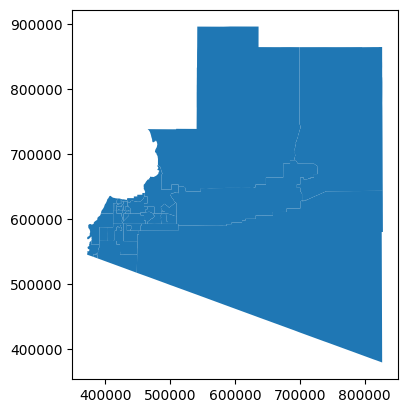

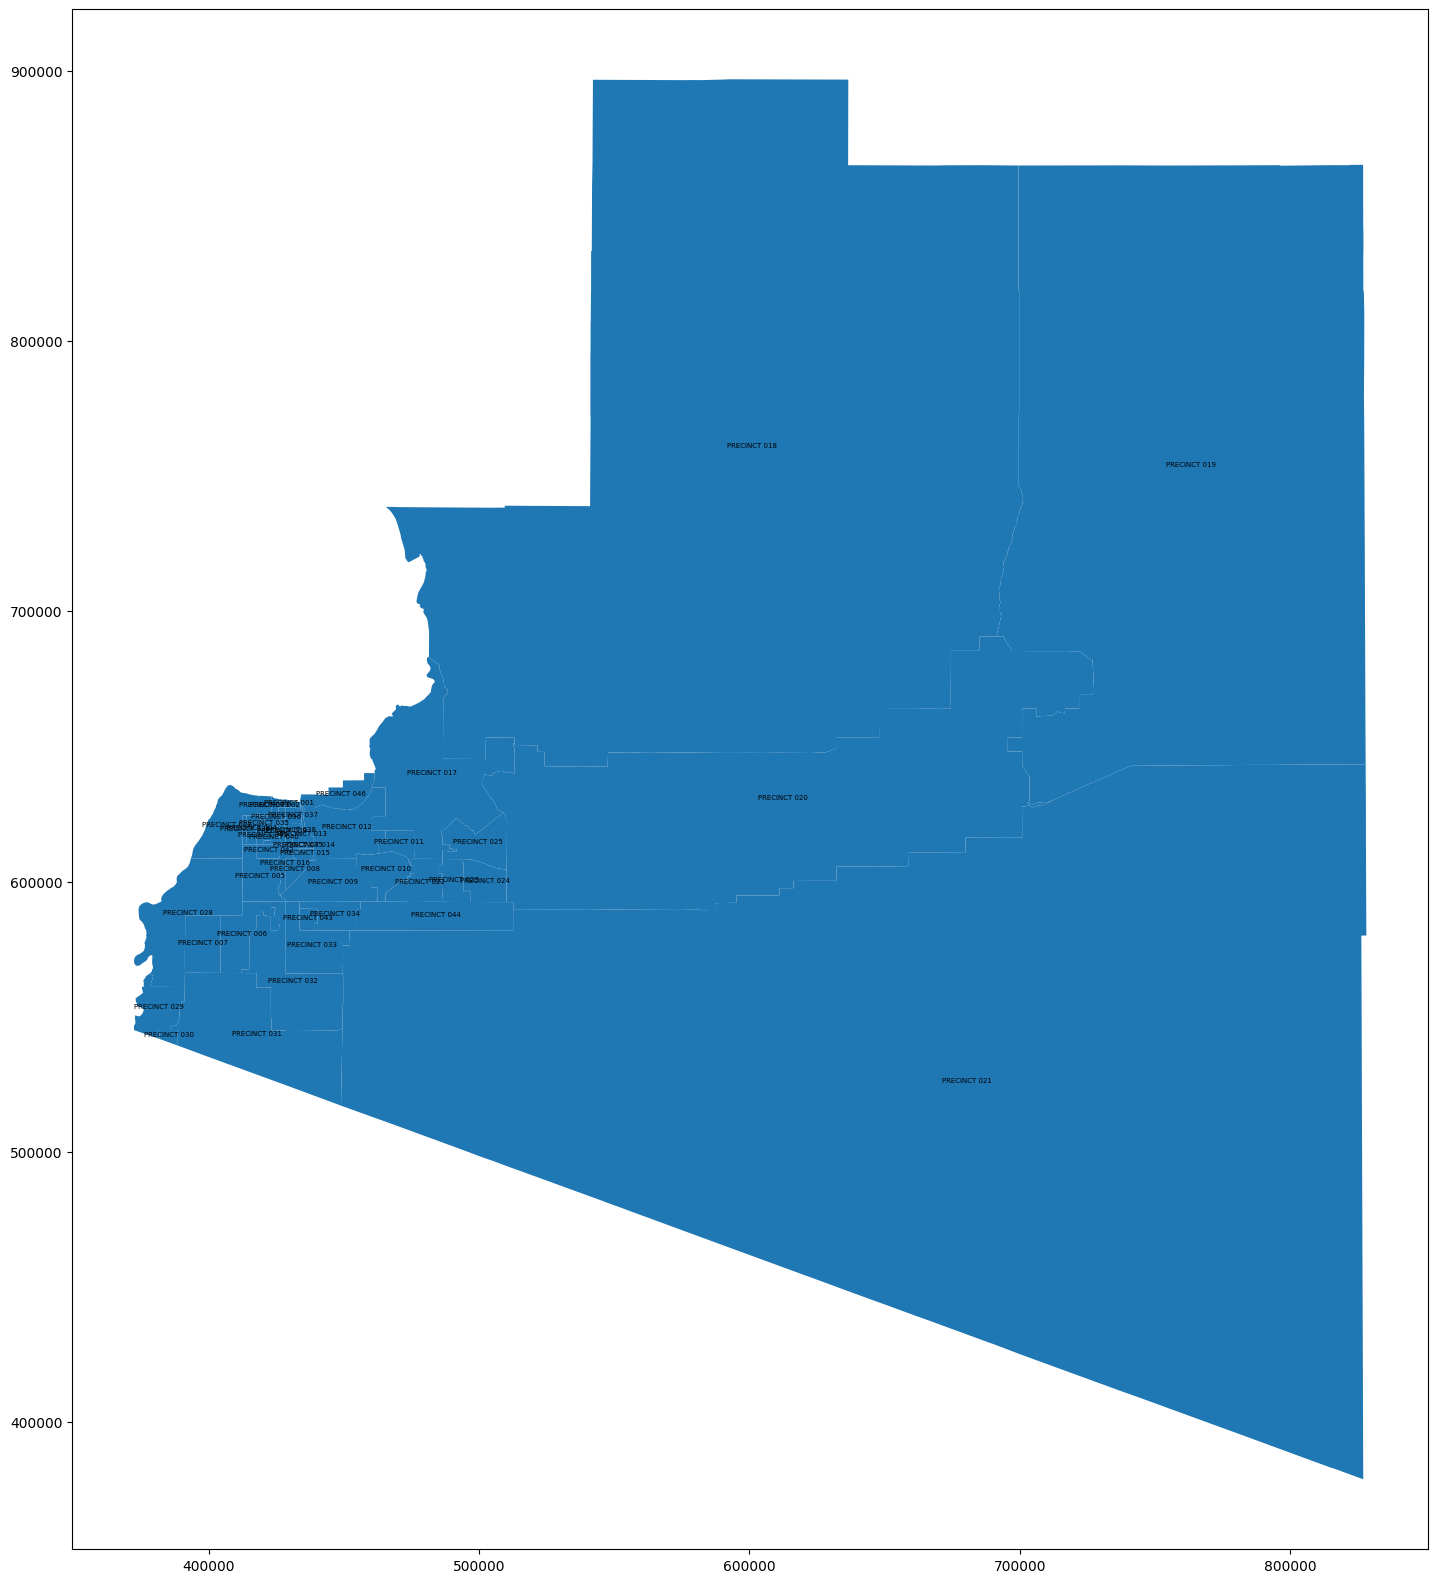

In [156]:
# Read the shapefile
shapefile_path_Yuma = './precinct_boundaries/yuma_2022/fwd2022voterprecinctmapasshapefiles/Voting_Pricincts_03_2023.shp'
gdf_Yuma_2022 = gpd.read_file(shapefile_path_Yuma)

print(gdf_Yuma_2022)
ax = gdf_Yuma_2022.plot()

# Create a larger plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the geometries
gdf_Yuma_2022.plot(ax=ax)

# Add labels to each geometry
for x, y, label in zip(gdf_Yuma_2022.geometry.centroid.x, gdf_Yuma_2022.geometry.centroid.y, gdf_Yuma_2022['NAME']):
    ax.text(x, y, label, fontsize=5, ha='center')  # Adjust font size as needed

plt.show()

After checking with voter file on L2, it is confirmed that districts 21 and 44 have no voters.

In [157]:
gdf_Yuma_final = yuma_rows.merge(gdf_Yuma_2022[['CODE', 'geometry']], 
                                       left_on='precinct', 
                                       right_on='CODE', 
                                       how='right')

# Drop the duplicate UNIQUE_ID column from the merged DataFrame
gdf_Yuma_final = gdf_Yuma_final.drop(columns=['CODE'])


# Display the final DataFrame
print(gdf_Yuma_final)

   county precinct  G22ATTDMAY  G22ATTRHAM  G22CORDKEN  G22CORDKUB  \
0    Yuma      006       560.0       320.0       517.0       451.0   
1    Yuma      013       404.0       350.0       386.0       288.0   
2    Yuma      015       376.0       600.0       364.0       323.0   
3    Yuma      011       424.0       791.0       404.0       353.0   
4    Yuma      010      1041.0      1868.0       944.0       864.0   
5    Yuma      022       537.0      1166.0       502.0       454.0   
6    Yuma      023       534.0      1078.0       510.0       423.0   
7     NaN      NaN         NaN         NaN         NaN         NaN   
8    Yuma      025       626.0      1663.0       572.0       505.0   
9    Yuma      020       463.0      1109.0       405.0       372.0   
10   Yuma      032       283.0       238.0       261.0       223.0   
11   Yuma      026       192.0       129.0       171.0       149.0   
12   Yuma      038       440.0       454.0       413.0       351.0   
13   Yuma      037  

## Combine county level PBER into state level

In [158]:
import geopandas as gpd
import pandas as pd

# List of GeoDataFrames
gdf_list = [
    gdf_Apache_final, gdf_Cochise_final, gdf_Cococino_final, gdf_Gila_final,
    gdf_Graham_final, gdf_Greenlee_final, gdf_Maricopa_final, gdf_La_Paz_final,
    gdf_Mohave_final, gdf_Navajo_final, gdf_Pima_final, gdf_Pinal_final,
    gdf_Santa_Cruz_final, gdf_Yavapai_final, gdf_Yuma_final
]

# Check and convert to GeoDataFrame if necessary, ensure CRS is set
target_crs = "EPSG:4326"  # WGS 84
valid_gdfs = []

for gdf in gdf_list:
    if not isinstance(gdf, gpd.GeoDataFrame):
        try:
            gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
        except KeyError:
            print(f"Missing geometry column in DataFrame: {gdf}")
            continue

    if gdf.crs is None:
        gdf.set_crs(target_crs, inplace=True)

    valid_gdfs.append(gdf.to_crs(target_crs))

# Combine reprojected GeoDataFrames into a single GeoDataFrame
combined_gdf = pd.concat(valid_gdfs, ignore_index=True)

combined_gdf


,county,precinct,G22ATTDMAY,G22ATTRHAM,G22CORDKEN,G22CORDKUB,G22CORRMYE,G22CORRTHO,G22GOVDHOB,G22GOVNWRI,...,GSTH30NVOT,GSTH30RBIS,GSTS30NVOT,G22USSWBUL,G22GOVWDEN,G22GOVWMER,G22USSWBOR,G22GOVWCAM,G22USSWROX,geometry
0,Apache,02 ALPINE,96.0,278.0,93.0,86.0,252.0,260.0,106.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,Apache,03 CANYON DE CHELLY,1412.0,168.0,1131.0,948.0,123.0,207.0,1407.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109.71666 36.26151, -109.71658 36.2..."
2,Apache,05 CHINLE,729.0,103.0,631.0,517.0,86.0,100.0,721.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109.81183 36.27512, -109.80810 36.2..."
3,Apache,09 CONCHO,307.0,1251.0,273.0,251.0,1106.0,1117.0,312.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109.53982 34.44871, -109.53928 34.4..."
4,Apache,10 CORNFIELDS,330.0,44.0,285.0,227.0,37.0,42.0,329.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-109.82694 35.53686, -109.82692 35.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,Yuma,030,908.0,203.0,840.0,705.0,188.0,177.0,890.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-114.76103 32.47876, -114.76103 32.4..."
1728,Yuma,029,894.0,205.0,848.0,648.0,178.0,185.0,903.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-114.78236 32.48699, -114.78236 32.4..."
1729,Yuma,031,1373.0,389.0,1332.0,1028.0,356.0,347.0,1375.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-114.76103 32.47876, -114.76104 32.4..."
1730,Yuma,045,223.0,188.0,199.0,172.0,176.0,170.0,222.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-114.62603 32.68392, -114.62463 32.6..."


In [159]:
# Remove duplicated columns
def remove_duplicated_columns(gdf):
    duplicates = gdf.columns[gdf.columns.duplicated()].unique()
    gdf = gdf.loc[:, ~gdf.columns.duplicated()]
    return gdf

# Clean field names to ensure they are unique and valid for shapefiles
def clean_field_names(gdf):
    new_columns = {}
    seen_columns = set()
    for col in gdf.columns:
        # Shorten the field name to 10 characters and remove non-ISO-8859-1 characters
        new_col = ''.join([c if ord(c) < 128 else '' for c in col])[:10]
        # Ensure the column name is unique
        if new_col in seen_columns:
            counter = 1
            new_col_temp = new_col
            while new_col_temp in seen_columns:
                new_col_temp = f"{new_col[:8]}{counter}"
                counter += 1
            new_col = new_col_temp
        seen_columns.add(new_col)
        new_columns[col] = new_col
    gdf.rename(columns=new_columns, inplace=True)
    return gdf

# Remove duplicated columns
combined_gdf = remove_duplicated_columns(combined_gdf)

# Clean the field names in your GeoDataFrame
cleaned_gdf = clean_field_names(combined_gdf)

# Check for duplicated columns after cleaning
if cleaned_gdf.columns.duplicated().any():
    print("There are still duplicated column names after cleaning.")
else:
    print("No duplicated columns after cleaning.")

# Save the GeoDataFrame to a shapefile
cleaned_gdf.to_file("combined_gdf.shp")


No duplicated columns after cleaning.


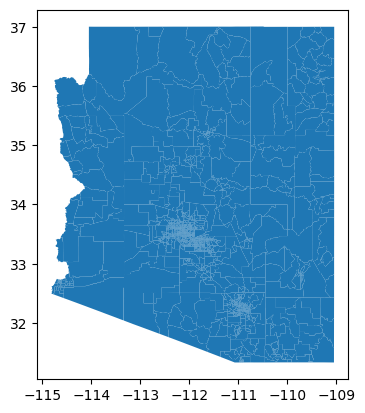

posx and posy should be finite values
posx and posy should be finite values


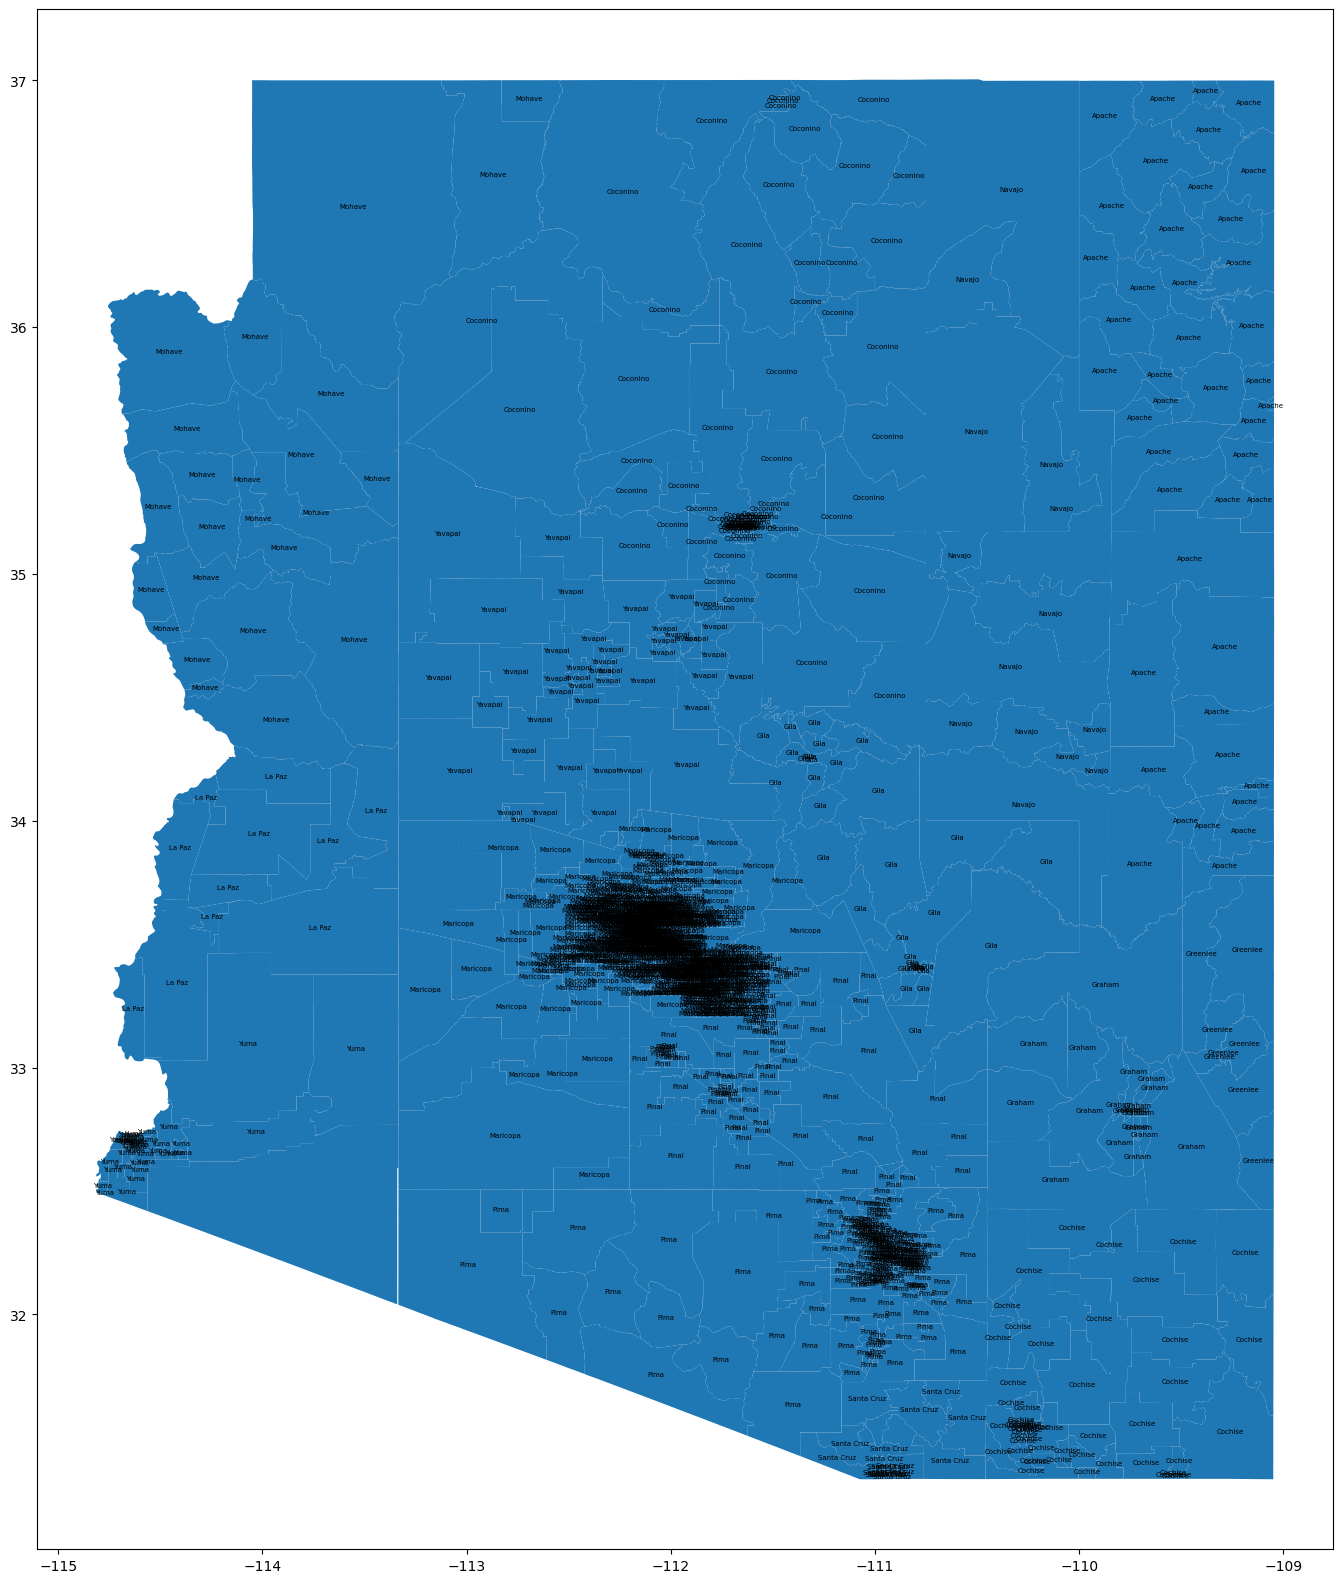

In [160]:
# Read the shapefile
shapefile_path_final = './combined_gdf.shp'
shapefile_final = gpd.read_file(shapefile_path_final)

ax = shapefile_final.plot()

# Create a larger plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the geometries
shapefile_final.plot(ax=ax)

# Add labels to each geometry
for x, y, label in zip(shapefile_final.geometry.centroid.x, shapefile_final.geometry.centroid.y, shapefile_final['county']):
    ax.text(x, y, label, fontsize=5, ha='center')  # Adjust font size as needed

plt.show()